# Imports and Set Up

#

1- Import all the libraries
2- Download the Summary History - Summary Statistics: earnings suprises in past quarters, number of analysts, etc.
3- Compustat quarterly variables: firm performance, size, leverage, profitability, liquidity, growth, age
4- Industry level variables: HHI, R&D, etc.
5- Execucomp variables: CEO characteristics, overconfidence, age, tenure, gender, education

In [2]:
import os
import wrds
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [3]:
previously_downloaded_ratios = True
previously_downloaded_age = True
previously_downloaded_compustat_quarterly = True
previously_downloaded_compustat_annual = True
previously_downloaded_segments = True
previously_downloaded_estimates = True
previously_downloaded_execucomp = True
previously_downloaded_Loughran_McDonald = True
ind_col = 'sich4'


In [4]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

In [5]:

# Access environment variables for WRDS username and password
wrds_username = os.environ.get("WRDS_USERNAME")
wrds_password = os.environ.get("WRDS_PASSWORD")

# 1 - Base dataframe: transcripts

In [5]:
transcripts = pd.read_pickle("../data/sxp1500_presentations_ceo_aggregated.pkl")

In [6]:
transcripts.gvkey.nunique()

1669

In [7]:
transcripts.columns

Index(['transcriptid', 'transcriptcomponentid_list', 'transcript_text',
       'audiolengthsec', 'companyid', 'companyname', 'companyofperson',
       'componentorder', 'componenttextpreview', 'delayreasontypeid',
       'delayreasontypename', 'exec_fullname', 'execid', 'gvkey', 'headline',
       'is_ceo', 'isdelayed_flag', 'keydeveventtypeid', 'keydeveventtypename',
       'keydevid', 'matched_name', 'mostimportantdateutc',
       'mostimportanttimeutc', 'proid', 'speakertypeid', 'speakertypename',
       'transcriptcollectiontypeid', 'transcriptcollectiontypename',
       'transcriptcomponenttypeid', 'transcriptcomponenttypename',
       'transcriptcreationdate_utc', 'transcriptcreationtime_utc',
       'transcriptpersonid', 'transcriptpersonname',
       'transcriptpresentationtypeid', 'transcriptpresentationtypename',
       'word_count', 'year', 'transcript_text_len',
       'transcriptcomponentid_ceospeech', 'processed'],
      dtype='object')

In [8]:
# check to see if there are duplicate transcriptid values per keydevid
transcripts.groupby(['keydevid'])['transcriptid'].apply(lambda x: x.nunique()>1).sum()

0

In [9]:
# number of words in transcript_text
transcripts['word_count_total'] = transcripts['transcript_text'].str.split().str.len()

In [10]:
transcripts = transcripts.drop_duplicates(subset=['keydevid'], keep='first')

In [11]:
database = transcripts[['companyid', 'keydevid', 'transcriptid', 'mostimportantdateutc', 'mostimportanttimeutc', 'gvkey', 'companyname', 'word_count_total']]

In [12]:
database['mostimportantdateutc_dt'] = pd.to_datetime(database['mostimportantdateutc'], format='%Y-%m-%d')
#database['year'] = database['mostimportantdateutc_dt'].dt.year
#database['month'] = database['mostimportantdateutc_dt'].dt.month

/var/folders/qr/1pq07r555gxgt22gqksl2tlw0000gn/T/ipykernel_83142/167126419.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  database['mostimportantdateutc_dt'] = pd.to_datetime(database['mostimportantdateutc'], format='%Y-%m-%d')


# 2 - Promises identified

In [13]:
promises = pd.read_csv("../data/sxp1500_presentations_ceo_aggregated_promises_expanded_cleaned_transcriptlevel_horizon.csv")

/var/folders/qr/1pq07r555gxgt22gqksl2tlw0000gn/T/ipykernel_83142/2671568783.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  promises = pd.read_csv("../data/LIWC-22 Results - sxp1500_presentations_ceo_aggr___ - LIWC Analysis_v11_horizon_v2_specificity.csv")


In [14]:
# create promise_id column, it is gvkey_transcriptid_2digitnumber (01, 02, 03, ...)

promises['promise_id'] = promises.groupby(['gvkey', 'transcriptid']).cumcount() + 1
promises['promise_id'] = promises['gvkey'].astype(str) + '_' + promises['transcriptid'].astype(str) + '_' + promises['promise_id'].apply(lambda x: f'{x:02d}')



In [15]:
list(promises.columns)

['Unnamed: 0',
 'transcriptid',
 'transcriptcomponentid_list',
 'audiolengthsec',
 'companyid',
 'companyname',
 'companyofperson',
 'componentorder',
 'componenttextpreview',
 'delayreasontypeid',
 'delayreasontypename',
 'exec_fullname',
 'execid',
 'gvkey',
 'headline',
 'is_ceo',
 'isdelayed_flag',
 'keydeveventtypeid',
 'keydeveventtypename',
 'keydevid',
 'matched_name',
 'mostimportantdateutc',
 'mostimportanttimeutc',
 'proid',
 'speakertypeid',
 'speakertypename',
 'transcriptcollectiontypeid',
 'transcriptcollectiontypename',
 'transcriptcomponenttypeid',
 'transcriptcomponenttypename',
 'transcriptcreationdate_utc',
 'transcriptcreationtime_utc',
 'transcriptpersonid',
 'transcriptpersonname',
 'transcriptpresentationtypeid',
 'transcriptpresentationtypename',
 'word_count',
 'year',
 'transcript_text_len',
 'transcriptcomponentid_ceospeech',
 'processed',
 '3-promise-horizon-v2',
 '1-promise-verbatim',
 '2-promise-explain',
 '3-promise-delivery-time',
 '4-promise-horizon',


In [16]:
promises['3-promise-horizon-v2'].value_counts()

3-promise-horizon-v2
unclear    81578
2          12392
10          8012
5           7653
4           7164
           ...  
260            1
202            1
262            1
382            1
216            1
Name: count, Length: 304, dtype: int64

### Cleaning up the horizons column

In [17]:
# if it contains 'unclear' or "Unclear" in the promise, then set the promise horizon to 'unclear'
promises.loc[promises['3-promise-horizon-v2'].str.contains('unclear', case=False, na=False), '3-promise-horizon-v2'] = 'unclear'


In [18]:
def process_value(value):
    if pd.isna(value):
        return np.nan
    if value == 'unclear':
        return np.nan
    if not str(value).replace('-', '').replace('.', '').isdigit():
        return np.nan
    if '-' in value:
        try:
            number1, number2 = value.split('-')
            return (float(number1) + float(number2)) / 2
        except ValueError:
            return np.nan
    try:
        return float(value)
    except ValueError:
        return np.nan

promises['promise_horizon_months'] = promises['3-promise-horizon-v2'].apply(process_value)


In [19]:
promises['promise_horizon_months'].describe()

count    92915.000000
mean        11.847990
std         22.283649
min          0.000000
25%          3.000000
50%          7.000000
75%         12.000000
max       1656.000000
Name: promise_horizon_months, dtype: float64

### Promises count

In [24]:
def process_promises(filtered_promises, suffix):
    # promises count
    filtered_promises[f'promises{suffix}_count'] = filtered_promises.groupby(['transcriptid'])['promise_id'].transform('nunique')

    # promises deliver date averaging
    filtered_promises[f'promises{suffix}_horizon'] = filtered_promises.groupby(['transcriptid'])[f'promise_horizon_months'].transform(lambda x: x.mean(skipna=True))

    # proportion of horizons that are nan per transcript id
    filtered_promises[f'promises{suffix}_horizon_nan'] = filtered_promises.groupby(['transcriptid'])['promise_horizon_months'].transform(lambda x: x.isna().sum()/len(x))
    
    filtered_promises[f'promises{suffix}_specificity_score'] = filtered_promises.groupby(['transcriptid'])['specificity_score'].transform(lambda x: x.isna().sum()/len(x))
    
    # Keeping relevant columns
    promise_columns = [column for column in filtered_promises.columns if f'promises{suffix}_' in column]
    promise_columns_keep = ['transcriptid']
    promise_columns_keep.extend(promise_columns)

    return filtered_promises[promise_columns_keep]


In [25]:
promises1 = promises[((promises['7-is-promise'] == 'yes') | (promises['7-is-promise'] == 'Yes')) &
                    ((promises['8-financial-guidance'] == 'no') | (promises['8-financial-guidance'] == 'No')) & 
                    ((promises['5-commitment-degree'] == 'strong-commitment') )]

promises1 = process_promises(promises1, '_1')

promises1.drop_duplicates(subset=['transcriptid'], keep='first', inplace=True)


/var/folders/qr/1pq07r555gxgt22gqksl2tlw0000gn/T/ipykernel_83142/165499302.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_promises[f'promises{suffix}_count'] = filtered_promises.groupby(['transcriptid'])['promise_id'].transform('nunique')
/var/folders/qr/1pq07r555gxgt22gqksl2tlw0000gn/T/ipykernel_83142/165499302.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_promises[f'promises{suffix}_horizon'] = filtered_promises.groupby(['transcriptid'])[f'promise_horizon_months'].transform(la

In [26]:
database = pd.merge(database, promises1, on='transcriptid', how='left')
database['promises_1_count'].fillna(0, inplace=True)

# 3 - Ratios

In [27]:

# Access environment variables for WRDS username and password
wrds_username = os.environ.get("WRDS_USERNAME")
wrds_password = os.environ.get("WRDS_PASSWORD")

In [28]:
# Download the ratio data from WRDS
if previously_downloaded_ratios == False:
    # Connect to WRDS using the provided username and password
    db = wrds.Connection(wrds_username=wrds_username, wrds_password=wrds_password)
    # download finratiofirm table
    ratios = db.get_table(library='wrdsapps_finratio_ibes', table='firm_ratio_ibes')
    # convert adate column to datetime, get year
    ratios['adate_dt'] = pd.to_datetime(ratios['adate'], format='%Y%m%d')
    ratios['year'] = ratios['adate_dt'].dt.year
    ratios = ratios[ratios['year'] >= 2005]
    ratios.to_pickle('../data/ratios.pkl')
else:
    # Load the ratio data from the pickle file
    ratios = pd.read_pickle('../data/ratios.pkl')

In [29]:
ratios

,gvkey,permno,adate,qdate,public_date,capei,be,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,dpr,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,efftax,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,gprof,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,int_debt,int_totdebt,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,short_debt,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,intcov,intcov_ratio,cash_ratio,quick_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ret_crsp,gsector,gicdesc,mktcap,price,ptb,peg_trailing,divyield,peg_1yrforward,peg_ltgforward,ffi5_desc,ffi5,ffi10_desc,ffi10,ffi12_desc,ffi12,ffi17_desc,ffi17,ffi30_desc,ffi30,ffi38_desc,ffi38,ffi48_desc,ffi48,ffi49_desc,ffi49,ticker,cusip,adate_dt,year
618,001004,54594.0,2005-05-31,2005-05-31,2005-07-31,-95.254090,332.833,0.636782,12.199039,33.905660,35.235294,32.672727,39.065217,0.783127,11.497512,0.0,0.024834,0.082602,0.045228,0.200142,0.028935,0.062208,0.085707,0.056957,0.061532,0.141735,0.060257,0.061603,0.060257,0.073472,0.055814,0.204411,0.580812,0.419188,0.426098,0.419188,0.069004,0.067985,0.120574,0.538365,0.267881,0.315344,3.737883,0.016219,0.383306,0.544112,0.386027,0.318313,0.122011,0.744140,3.000539,0.682501,0.570157,0.494520,1.326430,2.131266,2.060303,0.314563,1.368942,2.965424,168.876120,2.379733,1.037581,6.453029,9.010661,1.380040,2.376052,2.377767,0.0,0.0,0.0,-0.044905,0.143857,20,Industrials,585.660248,17.969999,1.759622,0.514410,NaN,0.814743,1.361364,CNSMR,1.0,SHOPS,7.0,SHOPS,9.0,MACHN,11.0,WHLSL,26.0,WHLSL,33.0,WHLSL,41.0,WHLSL,42.0,AIR,00036110,2005-05-31,2005.0
619,001004,54594.0,2005-05-31,2005-05-31,2005-08-31,-93.292826,332.833,0.636782,12.199039,33.207547,34.509804,32.000000,38.260870,0.767003,11.260780,0.0,0.024834,0.082602,0.045228,0.200142,0.028935,0.062208,0.085707,0.056957,0.061532,0.141735,0.060257,0.061603,0.060257,0.073472,0.055814,0.204411,0.580812,0.419188,0.426098,0.419188,0.069004,0.067985,0.120574,0.538365,0.267881,0.315344,3.737883,0.016219,0.383306,0.544112,0.386027,0.318313,0.122011,0.744140,3.000539,0.682501,0.570157,0.494520,1.326430,2.131266,2.060303,0.314563,1.368942,2.965424,168.876120,2.379733,1.037581,6.453029,9.010661,1.380040,2.376052,2.377767,0.0,0.0,0.0,-0.044905,-0.020590,20,Industrials,573.601612,17.600000,1.723392,0.503818,NaN,0.797967,1.333333,CNSMR,1.0,SHOPS,7.0,SHOPS,9.0,MACHN,11.0,WHLSL,26.0,WHLSL,33.0,WHLSL,41.0,WHLSL,42.0,AIR,00036110,2005-05-31,2005.0
620,001004,54594.0,2005-05-31,2005-05-31,2005-09-30,-92.220534,332.833,0.636782,12.199039,32.415094,33.686275,31.236364,37.347826,0.758187,11.131350,0.0,0.024834,0.082602,0.045228,0.200142,0.028935,0.062208,0.085707,0.056957,0.061532,0.141735,0.060257,0.061603,0.060257,0.073472,0.055814,0.204411,0.580812,0.419188,0.426098,0.419188,0.069004,0.067985,0.120574,0.538365,0.267881,0.315344,3.737883,0.016219,0.383306,0.544112,0.386027,0.318313,0.122011,0.744140,3.000539,0.682501,0.570157,0.494520,1.326430,2.131266,2.060303,0.314563,1.368942,2.965424,168.876120,2.379733,1.037581,6.453029,9.010661,1.380040,2.376052,2.377767,0.0,0.0,0.0,-0.044905,-0.023864,20,Industrials,567.008730,17.180000,1.703583,0.491795,NaN,0.745117,1.301515,CNSMR,1.0,SHOPS,7.0,SHOPS,9.0,MACHN,11.0,WHLSL,26.0,WHLSL,33.0,WHLSL,41.0,WHLSL,42.0,AIR,00036110,2005-05-31,2005.0
622,001004,54594.0,2005-05-31,2005-08-31,2005-10-31,-89.491674,341.310,0.587584,10.869662,25.285714,27.465517,25.693548,29.500000,0.671299,22.208389,0.0,0.027202,0.083424,0.048643,0.200519,0.032746,0.062272,0.091758,0.064729,0.069471,0.141735,0.068517,0.070186,0.068517,0.091350,0.066060,0.216114,0.593560,0.405990,0.441181,0.406173,0.076862,0.070731,0.076843,0.571607,0.263174,0.322307,3.584699,0.079766,0.392974,0.523984,0.404207,0.146458,0.122011,0.382303,2.964442,0.644685,0.566043,0.494517,1.305368,2.286016,2.299710,0.195542,1.194993,2.789482,162.373672,2.429414,

In [30]:
test = ratios[['gvkey', 'adate', 'qdate', 'roe']].head(10000)
ratios.gvkey.nunique()

8491

In [31]:
#ratio_columns = ['gvkey', 'adate', 'qdate', 'bm', 'pe_inc', 'pe_exi', 'ptb', 'npm', 'roa', 'roe', 'roce', 'cfm', 'debt_at', 'at_turn', 'rd_sale', 'adv_sale']
#ratios = ratios[ratio_columns]

In [32]:
ratios.sort_values(by=['gvkey', 'adate', 'qdate'], inplace=True)

In [33]:
ratios.drop_duplicates(subset=['gvkey', 'adate', 'qdate'], keep='last', inplace=True)

In [34]:
# add a ratio_ prefix to each column name except gvkey adate and qdate
ratios.columns = ['ratio_' + column if column not in ['gvkey', 'adate', 'qdate'] else column for column in ratios.columns]


In [35]:
# ldate is the last date between adate and qdate
ratios['ldate'] = ratios[['adate', 'qdate']].max(axis=1)


In [36]:
# earnings volatility: standard deviation of roa over the last 12 quarters
ratios['ratio_earnings_volatility'] = ratios.groupby(['gvkey'])['ratio_roa'].transform(lambda x: x.rolling(6).std())


In [37]:
ratios['ratio_earnings_volatility'].notna().sum()

222232

# 5 - Compustat Quarterly

In [38]:
previously_downloaded_compustat_quarterly = True
if previously_downloaded_compustat_quarterly == False:
    db = wrds.Connection(wrds_username=wrds_username, wrds_password=wrds_password)
    # download finratiofirm table
    query = """
    SELECT gvkey, datadate, indfmt, consol, popsrc, datafmt, fyr, actq, atq, ibq, niq, niy, epsfi12, oeps12, epsfxy, mkvaltq, prccq, prchq, prclq, saleq, cshoq, actq, lctq, xoprq, xrdq, intanq, txdbq, atq, dpq, aqpq, dlttq, dlcq, seqq
    FROM comp_na_daily_all.fundq
    WHERE fyearq >= 2003
    """
    compustat = db.raw_sql(query)
    compustat.to_pickle('../data/compustat_q.pkl')

else:
    # Load the ratio data from the pickle file
    compustat = pd.read_pickle('../data/compustat_q.pkl')

In [39]:
compustat=compustat[compustat.datafmt=='STD']
compustat=compustat[compustat.popsrc=='D']
compustat=compustat[compustat.consol=='C']
compustat=compustat[compustat.indfmt== 'INDL']

In [40]:

compustat['datadate'] = pd.to_datetime(compustat['datadate'], format='%Y%m%d')
compustat['month']=compustat['datadate'].dt.month
compustat['year']=compustat['datadate'].dt.year
compustat.drop_duplicates(['gvkey','datadate'], inplace=True)
compustat['gvkey'] = compustat['gvkey'].astype(int)

In [41]:
compustat

,gvkey,datadate,indfmt,consol,popsrc,datafmt,fyr,actq,atq,ibq,niq,niy,epsfi12,oeps12,epsfxy,mkvaltq,prccq,prchq,prclq,saleq,cshoq,lctq,xoprq,xrdq,intanq,txdbq,dpq,aqpq,dlttq,dlcq,seqq,month,year
0,1004,2003-08-31,INDL,C,D,STD,5,387.141,676.345,-1.996,-1.996,-1.996,-0.30,-0.19,-0.06,NaN,8.0100,8.4500,4.5900,152.114,31.850,187.861,150.646,NaN,45.935,NaN,NaN,NaN,174.735,78.390,290.455,8,2003
1,1004,2003-11-30,INDL,C,D,STD,5,383.765,666.178,1.654,0.916,-1.080,-0.25,-0.14,-0.01,NaN,10.4600,11.7000,7.3000,156.287,32.045,171.299,150.424,NaN,45.975,NaN,NaN,NaN,167.499,52.984,294.821,11,2003
2,1004,2004-02-29,INDL,C,D,STD,5,437.750,721.229,2.245,2.012,0.932,-0.21,-0.06,0.06,NaN,12.9200,16.8700,9.9000,159.233,32.245,131.977,151.586,NaN,46.007,NaN,NaN,NaN,261.004,7.586,296.434,2,2004
3,1004,2004-05-31,INDL,C,D,STD,5,432.204,709.292,2.662,2.572,3.504,0.11,0.18,0.14,NaN,9.5800,13.1100,8.6200,176.835,32.245,131.261,169.714,NaN,47.770,NaN,NaN,NaN,248.666,3.392,301.684,5,2004
4,1010,2003-03-31,INDL,C,D,STD,12,NaN,4705.100,29.800,90.500,90.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,631.500,0.001,NaN,582.900,NaN,129.100,NaN,47.000,NaN,2110.900,NaN,1174.000,3,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12858,329141,2024-09-30,INDL,C,D,STD,6,2.879,4.794,-4.728,-4.728,-4.728,-0.51,-0.49,-0.08,NaN,0.2091,0.4982,0.2065,0.522,82.963,12.013,4.555,0.921,0.869,0.000,0.060,NaN,4.100,4.153,-11.319,9,2024
12859,348784,2024-09-30,INDL,C,D,STD,6,89.961,381.220,-5.895,-5.895,-5.895,-1.73,-1.43,-0.42,289.0317,20.3200,25.9900,17.9150,0.000,14.224,34.706,6.313,NaN,0.000,0.000,0.289,NaN,10.282,18.581,275.602,9,2024
12860,348784,2024-12-31,INDL,C,D,STD,6,67.314,362.920,-14.167,-14.167,-20.062,-2.30,-1.36,-1.41,305.1316,20.9900,22.0800,15.7500,0.000,14.537,38.051,5.560,NaN,0.000,0.000,0.272,NaN,7.192,15.485,243.879,12,2024
12861,356289,2024-09-30,INDL,C,D,STD,6,32.794,180.997,0.842,0.842,0.842,NaN,NaN,0.02,NaN,NaN,NaN,NaN,16.005,30.822,36.133,15.065,NaN,73.238,15.301,0.024,NaN,58.166,7.470,45.827,9,2024


In [42]:
# EPA
compustat['EPS'] = np.where(compustat['cshoq'] != 0, compustat['niq'] / compustat['cshoq'], np.nan)

# roa
compustat['roa'] = np.where(compustat['atq'] != 0, compustat['niq'] / compustat['atq'], np.nan)

# roe
compustat['roe'] = np.where((compustat['prccq']* compustat['cshoq']) != 0, compustat['niq'] / (compustat['prccq']* compustat['cshoq']), np.nan)


# r&d share of total expense
compustat['rd_f'] = compustat['xrdq'] / compustat['xoprq'].where(compustat['xoprq'] != 0, np.nan)
compustat['rd_f'] = compustat['rd_f'].fillna(0)

# recognized intangible assets as part of total assets
compustat['intang_f'] = compustat['intanq'] / compustat['atq'].where(compustat['atq'] != 0, np.nan)
compustat['intang_f'] = compustat['intang_f'].fillna(0)

# depreciation as part of total assets
compustat['dpt_f'] = compustat['dpq'] / compustat['atq'].where(compustat['atq'] != 0, np.nan)
compustat['dpt_f'] = compustat['dpt_f'].fillna(0)

#Total merger
compustat['mergers'] = compustat['aqpq'].fillna(0)

# Leverage
compustat['leverage'] = (compustat['dlttq'] + compustat['dlcq']) / compustat['seqq']
compustat.loc[compustat['seqq'] == 0, 'leverage'] = np.nan



In [43]:

# 2.1: Cash flow (CF) = ibq + dpq
compustat['cf'] = compustat['ibq'] + compustat['dpq']


# 2.2: Market Value of Equity (MVE) = cshoq * prccq
compustat['mve'] = compustat['cshoq'] * compustat['prccq']

# 2.3: Book Debt 
#      A common approximation is atq - seqq - txdbq.
compustat['book_debt'] = compustat['atq'] - compustat['seqq']
compustat['book_debt'] = compustat['book_debt'] - compustat['txdbq'].fillna(0)

# 2.4: Tobin's Q = (MVE + Book Debt) / atq
compustat['tobin_q'] = (compustat['mve'] + compustat['book_debt']) / compustat['atq']

In [44]:
# earnings_volatility
compustat.sort_values(['gvkey', 'datadate'], inplace=True)
compustat['earnings_volatility'] = compustat.groupby(['gvkey'])['roa'].transform(lambda x: x.rolling(6).std())

In [45]:
from scipy.stats.mstats import winsorize

# Winsorize the variables at the 1% level
compustat['EPS'] = winsorize(compustat['EPS'], limits=[0.025, 0.025])
compustat['roa'] = winsorize(compustat['roa'], limits=[0.025, 0.025])
compustat['roe'] = winsorize(compustat['roe'], limits=[0.025, 0.025])
compustat['rd_f'] = winsorize(compustat['rd_f'], limits=[0.025, 0.025])
compustat['intang_f'] = winsorize(compustat['intang_f'], limits=[0.025, 0.025])
compustat['dpt_f'] = winsorize(compustat['dpt_f'], limits=[0.025, 0.025])
compustat['mergers'] = winsorize(compustat['mergers'], limits=[0.025, 0.025])
compustat['leverage'] = winsorize(compustat['leverage'], limits=[0.025, 0.025])
compustat['earnings_volatility'] = winsorize(compustat['earnings_volatility'], limits=[0.025, 0.025])
compustat['tobin_q'] = winsorize(compustat['tobin_q'], limits=[0.025, 0.025])


# Replace NaN values with 0
compustat = compustat.fillna(0)

In [46]:
compustat['roe'].describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .95, .99])

count    1.009875e+06
mean     6.765630e-01
std      2.851728e+02
min     -4.062416e-01
1%      -4.062416e-01
5%      -1.796553e-01
10%     -7.247141e-02
25%     -6.740168e-03
50%      0.000000e+00
75%      1.101937e-02
90%      2.495183e-02
95%      4.041958e-02
99%      1.747980e-01
max      2.133035e+05
Name: roe, dtype: float64

### Merge

In [47]:

database_temp = database[['transcriptid', 'gvkey', 'mostimportantdateutc']].merge(compustat, how='left', on='gvkey')
database_temp['mostimportantdateutc_dt'] = pd.to_datetime(database_temp['mostimportantdateutc'], format='%Y-%m-%d')
database_temp['qdate_diff'] = database_temp['mostimportantdateutc_dt'] - database_temp['datadate']
database_temp['qdate_diff'] = database_temp['qdate_diff'].dt.days
database_temp = database_temp[(database_temp['qdate_diff'] >= 0) & (database_temp['qdate_diff'] <= 75)]
database_temp.drop_duplicates(subset=['transcriptid'], inplace=True)
database_temp.drop(columns=['mostimportantdateutc_dt', 'qdate_diff','year', 'month'], inplace=True)


In [48]:
database_temp.drop_duplicates(subset= ['transcriptid'],inplace=True)
database_temp.drop(columns=['gvkey', 'mostimportantdateutc'], inplace=True)

In [49]:
database = database.merge(database_temp, how='left', on='transcriptid')

In [50]:
database.drop_duplicates(subset=['gvkey', 'datadate'], inplace=True)

# 6 - Compustat annual - industry codes

In [51]:
previously_downloaded_compustat_annual = True

if previously_downloaded_compustat_annual == False:
    db = wrds.Connection(wrds_username=wrds_username, wrds_password=wrds_password)
    # download finratiofirm table
    query = """
    SELECT gvkey, datadate, datafmt, popsrc, consol, indfmt, cusip, cik,  sich,  naicsh, sale, ppent, emp, xrd, xad
    FROM comp_na_daily_all.funda
    WHERE fyear >= 2000
    """
    compustata = db.raw_sql(query)
    compustata.to_pickle('../data/compustat_a.pkl')

else:
    # Load the ratio data from the pickle file
    compustata = pd.read_pickle('../data/compustat_a.pkl')

In [52]:
compustata=compustata[compustata.datafmt=='STD']
compustata=compustata[compustata.popsrc=='D']
compustata=compustata[compustata.consol=='C']
compustata=compustata[compustata.indfmt== 'INDL']

compustata.drop_duplicates(['gvkey','datadate'], inplace=True)


In [53]:
compustata['datadate'] = pd.to_datetime(compustata['datadate'], format='%Y%m%d')

compustata['month']=compustata['datadate'].dt.month
compustata['year']=compustata['datadate'].dt.year


In [54]:
compustata['sich'] = compustata['sich'].replace('', np.nan)
compustata = compustata.loc[compustata['sich'].notna()]
compustata.loc[:, 'sich4'] = compustata['sich'].astype(int).astype(str).str.pad(width=4, side='right', fillchar='0').astype(int)
compustata.loc[:, 'sich3'] = compustata['sich4'] // 10
compustata.loc[:, 'sich2'] = compustata['sich4'] // 100

# 7 - Create industry vars

### HHI

In [55]:
compustata['sale_nonneg'] = compustata['sale'].clip(lower=0)

In [56]:
total_sales = compustata.groupby(['year', ind_col])['sale_nonneg'].sum().reset_index(name=f'total_sales_{ind_col}')
compustata = compustata.merge(total_sales, on=['year', ind_col])
compustata[f'market_share_{ind_col}'] = compustata['sale_nonneg'] / compustata[f'total_sales_{ind_col}']

In [57]:
compustata[f'squared_market_share_{ind_col}'] = compustata[f'market_share_{ind_col}'] ** 2
hhi = compustata.groupby(['year', ind_col])[f'squared_market_share_{ind_col}'].sum().reset_index(name=f'hhi_{ind_col}')
compustata = compustata.merge(hhi, on=['year', ind_col])

In [58]:
compustata[f'hhi_{ind_col}'].describe()

count    176563.000000
mean          0.221379
std           0.209107
min           0.000000
25%           0.078879
50%           0.151264
75%           0.292322
max           1.000000
Name: hhi_sich4, dtype: float64

In [59]:
## Reverse HHI reversed value = (Max + Min) - original value
compustata[f'hhi_{ind_col}_reverse_ind'] = (compustata[f'hhi_{ind_col}'].max() + compustata[f'hhi_{ind_col}'].min()) - compustata[f'hhi_{ind_col}']


In [60]:
compustata[f'hhi_{ind_col}_reverse_ind'].notna().sum()

176563

### R&D intensity

In [61]:
### R&D intensity
compustata['rd_intensity'] = compustata['xrd'] / compustata['sale']
compustata['rd_intensity'] = compustata['rd_intensity'].fillna(0)

# industry average per year
compustata['rd_intensity_ind'] = compustata.groupby(['year', ind_col])['rd_intensity'].transform(lambda x: x.mean(skipna=True))

# 8 - compustat segments

In [62]:

if previously_downloaded_segments == False:

    wrds_username = os.getenv('WRDS_USERNAME')
    wrds_password = os.getenv('WRDS_PASSWORD')
    db = wrds.Connection(wrds_username=wrds_username, wrds_password=wrds_password)

    # replace with wrdssec.forms
    query = f"""
        SELECT gvkey, srcdate, datadate, sid, sales, stype, sics1
        FROM comp_segments_hist_daily.wrds_segmerged
    """
    
    segments = db.raw_sql(query)
    segments.to_csv('../data/compustat_segments.csv')
    db.close()
    
else:
    segments = pd.read_csv('../data/compustat_segments.csv')

In [63]:
segments.stype.value_counts()

stype
GEOSEG    1242530
BUSSEG    1151242
OPSEG      156762
STSEG        4608
Name: count, dtype: int64

## Number of segments for each firm

In [64]:
segments.drop_duplicates(['gvkey', 'datadate','srcdate'])
segments.drop_duplicates(['gvkey', 'datadate', 'sid'])
segments = segments[['gvkey', 'datadate', 'sid', 'sales', 'stype']]
segments['gvkey'] = segments['gvkey'].astype(int)

In [65]:
segments_n = segments[(segments['stype']=='BUSSEG') | (segments['stype']=='OPSEG')].groupby(['gvkey', 'datadate'])['sid'].nunique().reset_index()
segments_n = segments_n.rename(columns={'sid': 'n_segments'})

segments_n['year'] = segments_n['datadate'].astype(str).str.slice(0,4).astype(int)
segments_n = segments_n[['gvkey', 'year', 'n_segments']]

compustata['gvkey'] = compustata['gvkey'].astype(int)
compustata = compustata.merge(segments_n, on=['gvkey', 'year'], how='left',
                                  suffixes=('_df1', ''))
compustata['n_segments'].fillna(1,inplace=True)

## Strategy Uniqueness using Litov et al. (2012) method

In [66]:
seg_ind = 'sics1'

segments = pd.read_csv('../data/compustat_segments.csv')
segments['year'] = segments['datadate'].str.slice(0,4).astype(int)
segments = segments[(segments['stype'] == 'BUSSEG') | (segments['stype'] == 'OPSEG')]
segments = segments[['gvkey', 'year', 'sales', seg_ind ]]
segments = segments[segments['sales'] > 0]
segments = segments[segments[seg_ind].notnull()]
segments = segments[segments[seg_ind] != '']
segments = segments[segments[seg_ind] != 0]
segments[seg_ind] = segments[seg_ind].astype(int)
segments['year'] = segments['year'].astype(int)
segments['gvkey'] = segments['gvkey'].astype(int)
segments = segments.rename(columns={'gvkey': 'GVKEY'})
segments = segments.rename(columns={seg_ind: 'segment_sic'})
segments = segments.rename(columns={'sales': 'segment_sale'})
segments = segments.groupby(['GVKEY', 'year', 'segment_sic'])['segment_sale'].sum().reset_index(name='segment_sale')
segments['segment_sic'] = segments['segment_sic'].astype(int)

In [67]:

# Step 1
idx = segments.groupby(['GVKEY', 'year'])['segment_sale'].idxmax()
segments['primary_sic'] = segments.loc[idx, 'segment_sic']
segments['primary_sic'] = segments.groupby(['GVKEY', 'year'])['primary_sic'].transform('max')

# Step 2
total_sales = segments.groupby(['GVKEY', 'year'])['segment_sale'].transform('sum')
segments['norm_sale'] = segments['segment_sale'] / total_sales

# Step 3
firm_year_matrix = segments.pivot_table(index=['GVKEY', 'year', 'primary_sic'],
                                        columns='segment_sic',
                                        values='norm_sale').fillna(0)

# Step 4
actual_sales_matrix = segments.pivot_table(index=['GVKEY', 'year', 'primary_sic'],
                                           columns='segment_sic',
                                           values='segment_sale').fillna(0)

industry_year_sales = actual_sales_matrix.groupby(['primary_sic', 'year']).sum()

# Step 5
total_industry_sales = industry_year_sales.sum(axis=1)
norm_industry_year_sales = industry_year_sales.div(total_industry_sales, axis=0)

# Step 6
diff_matrix = firm_year_matrix.subtract(norm_industry_year_sales, axis=1)

# step 7: sum of squared differences
squared_diff_matrix = diff_matrix ** 2
sum_squared_diff = squared_diff_matrix.sum(axis=1)

uniqueness = sum_squared_diff.reset_index(name='strategy_unique')

In [68]:
uniqueness = uniqueness.rename(columns={'GVKEY': 'gvkey'})

In [69]:
uniqueness.drop_duplicates(['gvkey', 'year'], inplace=True)

In [70]:
# gvkey to int
uniqueness['gvkey'] = uniqueness['gvkey'].astype(int)
compustata['gvkey'] = compustata['gvkey'].astype(int)

In [71]:
compustata = compustata.merge(uniqueness, on=['gvkey', 'year'], how='left')

### Age

In [72]:
# Download the ratio data from WRDS
if previously_downloaded_age == False:
    # Connect to WRDS using the provided username and password
    db = wrds.Connection(wrds_username=wrds_username, wrds_password=wrds_password)
    # download finratiofirm table
    query = """
    SELECT gvkey, datadate 
    FROM comp_na_daily_all.funda
    """
    age = db.raw_sql(query)
    age.to_pickle('../data/compustat_age.pkl')

else:
    # Load the ratio data from the pickle file
    age = pd.read_pickle('../data/compustat_age.pkl')


In [73]:
age.drop_duplicates(inplace=True)
age['datadate_dt'] = pd.to_datetime(age['datadate'], format='%Y%m%d')
age['year'] = age['datadate_dt'].dt.year
age['first_year'] = age.groupby('gvkey')['year'].transform('min')
age['firm_age'] = age['year'] - age['first_year']
age = age[['gvkey', 'datadate', 'firm_age']]
age['gvkey'] = age['gvkey'].astype(int)
age.drop_duplicates(subset=['gvkey', 'datadate'], inplace=True)


In [74]:
age['datadate'] = pd.to_datetime(age['datadate'], format='%Y%m%d')


In [75]:
compustata = compustata.merge(age, how='left', on=['gvkey', 'datadate'])

### Merge


In [76]:
# drop year and month from compustata
compustata.drop(columns=['year', 'month'], inplace=True)
compustata['gvkey'] = compustata['gvkey'].astype(int)
compustata.rename(columns={'datadate': 'datadate_annual'}, inplace=True)
database_select = database[['gvkey', 'datadate']]
database_select_merge = pd.merge(database_select, compustata, how='outer', on=['gvkey'])
database_select_merge.sort_values(['gvkey', 'datadate_annual', 'datadate'], inplace=True)
database_select_merge['datadate_diff'] = database_select_merge['datadate'] - database_select_merge['datadate_annual']
database_select_merge['datadate_diff'] = database_select_merge['datadate_diff'].dt.days
database_select_merge = database_select_merge[(database_select_merge['datadate_diff'] >= 0) & (database_select_merge['datadate_diff'] <= 360)]
database_select_merge.drop_duplicates(subset=['gvkey', 'datadate'], inplace=True)
database = database.merge(database_select_merge, how='left', on=['gvkey', 'datadate'])
database.drop_duplicates(subset=['gvkey', 'datadate'], inplace=True)

# 9 - IBES data

In [77]:

if previously_downloaded_estimates == False:

    wrds_username = os.getenv('WRDS_USERNAME')
    wrds_password = os.getenv('WRDS_PASSWORD')
    db_wrds = wrds.Connection(wrds_username=wrds_username, wrds_password=wrds_password)

    # replace with wrdssec.forms
    query = f"""
        SELECT *
        FROM tr_ibes.statsum_epsus
    """

    estimates = db_wrds.raw_sql(query)
    estimates.to_csv('../data/estimates_summary.csv')
    db_wrds.close()

else:
    estimates = pd.read_csv('../data/estimates_summary.csv')



/var/folders/qr/1pq07r555gxgt22gqksl2tlw0000gn/T/ipykernel_83142/2151060840.py:18: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  estimates = pd.read_csv('../data/estimates_summary.csv')


In [78]:
estimates = estimates[(estimates['fiscalp']=='QTR')]

In [79]:
estimates = estimates.dropna(subset=['fpedats'])
estimates = estimates[estimates['fpedats'] != 'None']
estimates['year'] = estimates['fpedats'].astype(str).str.slice(0,4).astype(int)

In [80]:
estimates = estimates.dropna(subset=['actual'])
estimates = estimates.dropna(subset=['meanest'])

In [81]:
estimates = estimates[estimates['year']>2005]

In [82]:
estimates['earnings_surprise'] = (estimates['actual'] - estimates['meanest'])
estimates['earnings_surprise_norm'] = (estimates['actual'] - estimates['meanest']) / estimates['meanest']

# Replace infinite values with NaN
estimates = estimates.replace([np.inf, -np.inf], np.nan)

In [83]:
estimates['fpedats_dt'] = pd.to_datetime(estimates['fpedats'], format='%Y-%m-%d')
estimates['est_year'] = estimates['fpedats_dt'].dt.year
estimates['est_month'] = estimates['fpedats_dt'].dt.month

In [84]:
estimates.drop(columns='year', inplace=True)

In [85]:
test=estimates.head(10000)

In [86]:
test=estimates.head(10000)[['ticker', 'statpers', 'fpedats', 'actdats_act', 'actual', 'meanest', 'earnings_surprise', 'earnings_surprise_norm', 'est_year', 'est_month']]

In [87]:
estimates = estimates.sort_values(['ticker', 'fpedats', 'statpers']).drop_duplicates(['ticker', 'fpedats'], keep='last')

In [88]:
estimates.columns

Index(['Unnamed: 0', 'ticker', 'cusip', 'oftic', 'cname', 'statpers',
       'measure', 'fiscalp', 'fpi', 'estflag', 'curcode', 'numest', 'numup',
       'numdown', 'medest', 'meanest', 'stdev', 'highest', 'lowest', 'usfirm',
       'fpedats', 'actual', 'actdats_act', 'acttims_act', 'anndats_act',
       'anntims_act', 'curr_act', 'earnings_surprise',
       'earnings_surprise_norm', 'fpedats_dt', 'est_year', 'est_month'],
      dtype='object')

### Merge

In [89]:
database['cusip'] = database['cusip'].str[:8]

In [90]:
database_select = database[['cusip', 'datadate']]

In [91]:
database_select.drop_duplicates(inplace=True)

/var/folders/qr/1pq07r555gxgt22gqksl2tlw0000gn/T/ipykernel_83142/2264080731.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  database_select.drop_duplicates(inplace=True)


In [92]:
database_select = database_select.merge(estimates, how='outer', on=['cusip'])

In [93]:
database_select['datadate_diff'] = database_select['datadate'] - database_select['fpedats_dt']
database_select['datadate_diff'] = database_select['datadate_diff'].dt.days

In [94]:
database_select = database_select[(database_select['datadate_diff'] >= -15) & (database_select['datadate_diff'] <= 15)]

In [95]:
database_select.shape

(59673, 34)

In [96]:
database_select['datadate_diff'].describe()

count    59673.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: datadate_diff, dtype: float64

In [97]:
database = database.merge(database_select, how='left', on=['cusip', 'datadate'])

In [98]:
database_select['meanest'].describe()

count    59673.000000
mean         0.702017
std          1.140100
min        -35.530000
25%          0.200000
50%          0.480000
75%          0.930000
max         49.980000
Name: meanest, dtype: float64

# 10 - Execucomp data and CEO compensation

In [99]:
if previously_downloaded_execucomp == False:
        
        wrds_username = os.getenv('WRDS_USERNAME')
        wrds_password = os.getenv('WRDS_PASSWORD')
        db_wrds = wrds.Connection(wrds_username=wrds_username, wrds_password=wrds_password)
    
        # replace with wrdssec.forms
        query = f"""
            SELECT *
            FROM  comp_execucomp.anncomp
            WHERE ceoann='CEO'
        """
        
        execucomp = db_wrds.raw_sql(query)
        execucomp['gvkey'] = execucomp['gvkey'].astype(int)

        execucomp.to_csv('../data/execucomp.csv')
        db_wrds.close()

else:
    execucomp = pd.read_csv('../data/execucomp.csv')
    

/var/folders/qr/1pq07r555gxgt22gqksl2tlw0000gn/T/ipykernel_83142/2108971750.py:21: DtypeWarning: Columns (78,81,83) have mixed types. Specify dtype option on import or set low_memory=False.
  execucomp = pd.read_csv('../data/execucomp.csv')


In [100]:
execucomp.shape

(59659, 108)

### ceo duality

In [101]:
# whether the title collumn contains chmn or chairman
execucomp['ceo_dual'] = execucomp['title'].str.contains('chmn|chairman', case=False)

In [102]:
execucomp['ceo_dual'].value_counts()

ceo_dual
True     35012
False    24453
Name: count, dtype: int64

In [103]:
execucomp[execucomp['ceo_dual']==1][['title']]

,title
0,chmn.
1,chmn.
2,Chairman & CEO
3,Chairman & CEO
4,Chairman & CEO
...,...
59647,CEO & Chairman of the Board
59648,CEO & Chairman of the Board
59649,CEO & Chairman of the Board
59650,CEO & Chairman of the Board


### director

In [104]:
execucomp['ceo_director'] = execucomp['execdir']

### options compensation

In [105]:
execucomp['ceo_options_compensation'] = execucomp['opt_unex_exer_est_val']/execucomp['salary']
execucomp['ceo_options_compensation_log'] = np.log(execucomp['ceo_options_compensation'])

/Users/majid/Dropbox/Promises/transcripts_wrds/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### option awards

In [106]:
execucomp['ceo_option_awards'] = execucomp['option_awards_blk_value']/execucomp['salary']
execucomp['ceo_option_awards_log'] = np.log(execucomp['ceo_option_awards'])

/Users/majid/Dropbox/Promises/transcripts_wrds/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### ceo gender

In [107]:
execucomp['ceo_gender'] = execucomp['gender']

In [108]:
execucomp['ceo_gender'].value_counts()

ceo_gender
MALE      57660
FEMALE     1999
Name: count, dtype: int64

In [109]:
# gender dummy
execucomp['ceo_gender_dummy'] = execucomp['ceo_gender'].apply(lambda x: 1 if x=='MALE' else 0)

### ceo age

In [110]:
execucomp['ceo_age'] = execucomp['age']

### ceo tenure

In [111]:
# First, make sure your DataFrame is sorted
execucomp = execucomp.sort_values(by=['gvkey', 'execid', 'year'])

# Create a group identifier for consecutive years
execucomp['year_group'] = execucomp.groupby(['gvkey', 'execid'])['year'].diff().ne(1).cumsum()

# Create the ceo_tenure variable
execucomp['ceo_tenure'] = execucomp.groupby(['gvkey', 'execid', 'year_group']).cumcount() + 1

# Drop the temporary 'year_group' column
execucomp.drop(columns=['year_group'], inplace=True)

In [112]:
test = execucomp[['gvkey', 'execid', 'year', 'ceo_tenure']]

In [113]:
test.head(200)

,gvkey,execid,year,ceo_tenure
0,1004,9248,1994.0,1
1,1004,9248,1995.0,2
2,1004,9249,1996.0,1
3,1004,9249,1997.0,2
4,1004,9249,1998.0,3
...,...,...,...,...
195,1078,14300,2001.0,3
196,1078,14300,2002.0,4
197,1078,14300,2003.0,5
198,1078,14300,2004.0,6


### other vars

In [114]:
execucomp['ceo_total_compensation'] = execucomp['salary'] + execucomp['bonus'] + execucomp['othcomp']
execucomp['ceo_total_compensation_log'] = np.log(execucomp['ceo_total_compensation'])

execucomp['ceo_total_deferred_compensation'] = execucomp['defer_balance_tot'] + execucomp['defer_contrib_co_tot'] + execucomp['defer_contrib_exec_tot']
execucomp['ceo_total_deferred_compensation_log'] = np.log(execucomp['ceo_total_deferred_compensation'])

execucomp['ceo_total_shares_owned'] = execucomp['shrown_excl_opts'] + execucomp['shrown_tot']
execucomp['ceo_total_shares_owned_log'] = np.log(execucomp['ceo_total_shares_owned'])



/Users/majid/Dropbox/Promises/transcripts_wrds/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/majid/Dropbox/Promises/transcripts_wrds/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/majid/Dropbox/Promises/transcripts_wrds/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/majid/Dropbox/Promises/transcripts_wrds/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/majid/Dropbox/Promises/transcripts_wrds/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value enco

In [115]:
execucomp['ceo_years_left'] = execucomp.groupby(['gvkey', 'execid'])['year'].transform('max') - execucomp['year']


In [116]:
execucomp['ceo_years_left'].describe()

count    59659.000000
mean         4.296334
std          4.380936
min          0.000000
25%          1.000000
50%          3.000000
75%          6.000000
max         31.000000
Name: ceo_years_left, dtype: float64

### Merge

In [117]:
database['year'] = database['datadate'].dt.year

In [118]:
execucomp_select = execucomp[['exec_fullname', 'gvkey', 'execid', 'year', 'title', 'ceo_dual', 'ceo_director', 'ceo_options_compensation', 'ceo_options_compensation_log', 'ceo_option_awards', 'ceo_option_awards_log', 'ceo_gender', 'ceo_gender_dummy', 'ceo_age', 'ceo_tenure', 'ceo_total_compensation', 'ceo_total_compensation_log', 'ceo_total_deferred_compensation', 'ceo_total_deferred_compensation_log', 'ceo_total_shares_owned', 'ceo_total_shares_owned_log', 'ceo_years_left'
]]

In [119]:
execucomp_select.drop_duplicates(subset=['gvkey', 'year'], inplace=True)

/var/folders/qr/1pq07r555gxgt22gqksl2tlw0000gn/T/ipykernel_83142/3801021852.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  execucomp_select.drop_duplicates(subset=['gvkey', 'year'], inplace=True)


In [120]:
database = database.merge(execucomp_select, how='left', on=['gvkey', 'year'], suffixes=('', '_excomp'))

# 11 - Execucomp - CEO Functional Backgorund

In [121]:
if previously_downloaded_execucomp == False:
        
        wrds_username = os.getenv('WRDS_USERNAME')
        wrds_password = os.getenv('WRDS_PASSWORD')
        db_wrds = wrds.Connection(wrds_username=wrds_username, wrds_password=wrds_password)
    
        # replace with wrdssec.forms
        query = f"""
            SELECT *
            FROM  comp_execucomp.anncomp
            WHERE ceoann='CEO'
        """
        
        execucomp = db_wrds.raw_sql(query)
        execucomp['gvkey'] = execucomp['gvkey'].astype(int)

        execucomp.to_csv('../data/execucomp.csv')
        db_wrds.close()

else:
    execucomp = pd.read_csv('../data/execucomp.csv')
    

/var/folders/qr/1pq07r555gxgt22gqksl2tlw0000gn/T/ipykernel_83142/2108971750.py:21: DtypeWarning: Columns (78,81,83) have mixed types. Specify dtype option on import or set low_memory=False.
  execucomp = pd.read_csv('../data/execucomp.csv')


In [122]:
execucomp.head()

,Unnamed: 0,exec_fullname,cfoann,execdir,old_datafmt_flag,interlock,reprice,execrank,co_per_rol,coname,titleann,ceoann,salary,bonus,stock_awards,option_awards,noneq_incent,pension_chg,othcomp,total_sec,total_curr,total_alt1,total_alt2,term_pymt,chg_ctrl_pymt,shrown_tot,shrown_tot_pct,shrown_excl_opts,shrown_excl_opts_pct,opt_exer_num,opt_exer_val,shrs_vest_num,shrs_vest_val,age,option_awards_num,option_awards_fv,stock_awards_fv,opt_unex_exer_num,opt_unex_unexer_num,opt_unex_exer_est_val,opt_unex_unexer_est_val,stock_unvest_num,stock_unvest_val,eip_unearn_num,eip_unearn_val,pension_value_tot,pension_pymts_tot,defer_contrib_exec_tot,defer_contrib_co_tot,defer_earnings_tot,defer_withdr_tot,defer_balance_tot,defer_rpt_as_comp_tot,execrankann,othann,tdc1,tdc2,rstkgrnt,option_awards_blk_value,option_awards_rpt_value,ltip,allothtot,allothpd,sal_pct,total_curr_pct,total_sec_pct,total_alt1_pct,total_alt2_pct,tdc1_pct,tdc2_pct,ret_yrs,comment,gvkey,execid,year,rstkvyrs,becameceo,joined_co,rejoin,leftofc,leftco,releft,pceo,pcfo,title,reason,exec_lname,exec_fname,exec_mname,gender,nameprefix,page,cusip,exchange,address,city,state,zip,tele,sicdesc,naicsdesc,inddesc,spcode,ticker,sub_tele,naics,spindex,sic
0,0,Ira A. Eichner,NaN,1.0,1.0,0.0,0.0,NaN,5622.0,AAR CORP,chmn. & CEO,CEO,480.0,265.0,NaN,NaN,NaN,NaN,160.2,NaN,745.0,NaN,NaN,NaN,NaN,NaN,NaN,440.071,2.70,0.0,0.000,NaN,NaN,64.0,30.000,NaN,NaN,44.800,71.20,154.700,126.800,15.000,228.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,156.6,1255.855,1111.450,206.250,144.405,259.419,0.0,3.6,0.0,1.223,4.313,NaN,NaN,NaN,NaN,54.004,20.0,*Portion of bonus pd. in restr. stk. (10%).,1004,9248,1994.0,NaN,1955-01-01,NaN,NaN,1996-10-01,1999-05-31,NaN,NaN,NaN,chmn.,RESIGNED,Eichner,Ira,A.,MALE,Mr.,94.0,00036110,NYS,"One AAR Place, 1100 North Wood Dale Road",Wood Dale,IL,60191,630 227 2000,"MACHINERY, EQUIPMENT, AND SUPPLIES",Transportation Equipment and Supplies (except ...,Aerospace & Defense,SM,AIR,630.0,423860,2010.0,5080.0
1,1,Ira A. Eichner,NaN,1.0,1.0,0.0,0.0,NaN,5622.0,AAR CORP,chmn. & CEO,CEO,498.4,503.1,NaN,NaN,NaN,NaN,4.7,NaN,1001.5,NaN,NaN,NaN,NaN,NaN,NaN,451.953,2.90,0.0,0.000,NaN,NaN,65.0,30.000,NaN,NaN,68.000,78.00,678.500,539.250,31.159,689.393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1466.230,1336.200,330.000,130.030,330.170,0.0,4.7,0.0,3.833,34.430,NaN,NaN,NaN,16.752,20.221,20.0,NaN,1004,9248,1995.0,NaN,1955-01-01,NaN,NaN,1996-10-01,1999-05-31,NaN,NaN,NaN,chmn.,RESIGNED,Eichner,Ira,A.,MALE,Mr.,94.0,00036110,NYS,"One AAR Place, 1100 North Wood Dale Road",Wood Dale,IL,60191,630 227 2000,"MACHINERY, EQUIPMENT, AND SUPPLIES",Transportation Equipment and Supplies (except ...,Aerospace & Defense,SM,AIR,630.0,423860,2010.0,5080.0
2,2,David P. Storch,NaN,1.0,1.0,0.0,0.0,NaN,5623.0,AAR CORP,pres. & CEO,CEO,450.5,500.0,NaN,NaN,NaN,NaN,98.0,NaN,950.5,NaN,NaN,NaN,NaN,NaN,NaN,181.766,1.00,99.0,1262.035,NaN,NaN,44.0,250.161,NaN,NaN,69.161,313.10,586.045,3931.017,35.913,1113.303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,2853.619,2672.334,361.799,1443.320,3038.390,0.0,98.0,0.0,29.120,35.573,NaN,NaN,NaN,138.498,206.665,19.0,*Excl. 20% of bonus paid in restricted stock.,1004,9249,1996.0,NaN,1996-10-09,NaN,NaN,2018-05-31,NaN,NaN,NaN,NaN,Chairman & CEO,NaN,Storch,David,P.,MALE,Mr.,72.0,00036110,NYS,"One AAR Place, 1100 North Wood Dale Road",Wood Dale,IL,60191,630 227 2000,"MACHINERY, EQUIPMENT, AND SUPPLIES",Transportation Equipment and Supplies (except ...,Aerospace & Defense,SM,AIR,630.0,423860,2010.0,5080.0
3,3,David P. Storch,NaN,1.0,1.0,0.0,0.0,NaN,5623.0,AAR CORP,pres. & CEO,CEO,550.0,750.0,NaN,NaN,NaN,NaN,99.8,NaN,1300.0,NaN,NaN,NaN,NaN,NaN,NaN,220.106,0.79,0.0,0.000,NaN,NaN,45.0,345.000,NaN,NaN,310.744,607.62,3103.891,5735.553,58.482,1546.118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,4440.298,1911.675,511.875,2528.623,5696.996,0.0,99.8,0.0,22.087,36.770,NaN,NaN,NaN,55.602,-28.464,20.0,*Excl. 20% of bonus paid in restricted stock.,1004,9249,1997.0,NaN,1996-10-09,NaN,NaN,2018-05-31

In [123]:
boardex = pd.read_stata('../data/NA - BoardEx - Organization - Composition of Officers, Directors and Senior Managers.dta')

In [124]:
boardex.head()

,CompanyID,DirectorID,DirectorName,CompanyName,RoleName,DateStartRole,DateEndRole,Seniority
0,2.0,372547.0,Ambassador Gerald Carmen,OrgHarvest Inc (Home Shopping Latino Inc prior...,Director - SD,1998-07-01,NaT,Supervisory Director
1,2.0,533652.0,Paul Schlosberg,OrgHarvest Inc (Home Shopping Latino Inc prior...,Director - SD,2020-04-01,NaT,Supervisory Director
2,2.0,754463.0,Troy Taylor,OrgHarvest Inc (Home Shopping Latino Inc prior...,Chairman,NaT,NaT,Supervisory Director
3,2.0,1326382.0,Jimmy Ng,OrgHarvest Inc (Home Shopping Latino Inc prior...,Director - SD,NaT,NaT,Supervisory Director
4,3.0,59796.0,Steve Key,1 800 CONTACTS INC (De-listed 09/2007),Independent Director,2005-07-28,2007-09-07,Supervisory Director


In [125]:
# covert DateEndRole and DateStartRole to datetime - format is YYYY-MM-DD
boardex['DateEndRole'] = pd.to_datetime(boardex['DateEndRole'], format='%Y-%m-%d')
boardex['DateStartRole'] = pd.to_datetime(boardex['DateStartRole'], format='%Y-%m-%d')


In [126]:
# RoleStartYear is the year when the role started
# if month is greater than 6, then it is the next year
boardex['RoleStartYear'] = boardex['DateStartRole'].dt.year
boardex['RoleEndYear'] = boardex['DateEndRole'].dt.year

# if month is greater than 6, then it is the next year
boardex['RoleStartYear'] = np.where(boardex['DateStartRole'].dt.month > 6, boardex['DateStartRole'].dt.year + 1, boardex['DateStartRole'].dt.year)

boardex['RoleEndYear'] = np.where(boardex['DateEndRole'].dt.month > 6, boardex['DateEndRole'].dt.year + 1, boardex['DateEndRole'].dt.year)

In [127]:
# if roleendyera is empty, replace with 2024
boardex['RoleEndYear'] = np.where(boardex['RoleEndYear'].isna(), 2024, boardex['RoleEndYear'])



In [128]:
boardex['RoleLength'] = boardex['RoleEndYear'] - boardex['RoleStartYear'] + 1

In [129]:
titles_cleaned = pd.read_pickle('../data/ceo_funcational_background_titles2_ceo_role.pkl')

In [130]:
titles_cleaned.columns

Index(['RoleName', 'processed', 'primary_functional_area', 'is_ceo_role'], dtype='object')

In [131]:
titles_cleaned = pd.merge(boardex, titles_cleaned, on=['RoleName'], how='left')

In [132]:
titles_cleaned[['RoleName', 'primary_functional_area']].sample(20)

,RoleName,primary_functional_area
863177,Director - SD,Other/Unclear
1013665,Principal,Other/Unclear
1978388,Independent Director,Other/Unclear
689549,Director - SD,Other/Unclear
1366366,Chairman,Other/Unclear
1745532,Vice President,Other/Unclear
815309,President/CEO,Other/Unclear
1250685,Chairman/President/CEO,Other/Unclear
1817225,Chairman,Other/Unclear
229151,Division CTO,Technology/Product/Engineering/Science


In [133]:
titles_cleaned['primary_functional_area'].value_counts()

primary_functional_area
Other/Unclear                             1468740
Finance/Accounting                         137110
Sales/Marketing                            106674
Operations/Supply Chain                     96547
Technology/Product/Engineering/Science      76564
Legal/Compliance/Regulatory/Risk            67104
Human Resources                             26048
Strategy                                    24971
Administrative                              12827
Name: count, dtype: int64

In [134]:
titles_cleaned

,CompanyID,DirectorID,DirectorName,CompanyName,RoleName,DateStartRole,DateEndRole,Seniority,RoleStartYear,RoleEndYear,RoleLength,processed,primary_functional_area,is_ceo_role
0,2.0,372547.0,Ambassador Gerald Carmen,OrgHarvest Inc (Home Shopping Latino Inc prior...,Director - SD,1998-07-01,NaT,Supervisory Director,1999.0,2024.0,26.0,1,Other/Unclear,No
1,2.0,533652.0,Paul Schlosberg,OrgHarvest Inc (Home Shopping Latino Inc prior...,Director - SD,2020-04-01,NaT,Supervisory Director,2020.0,2024.0,5.0,1,Other/Unclear,No
2,2.0,754463.0,Troy Taylor,OrgHarvest Inc (Home Shopping Latino Inc prior...,Chairman,NaT,NaT,Supervisory Director,NaN,2024.0,NaN,1,Other/Unclear,No
3,2.0,1326382.0,Jimmy Ng,OrgHarvest Inc (Home Shopping Latino Inc prior...,Director - SD,NaT,NaT,Supervisory Director,NaN,2024.0,NaN,1,Other/Unclear,No
4,3.0,59796.0,Steve Key,1 800 CONTACTS INC (De-listed 09/2007),Independent Director,2005-07-28,2007-09-07,Supervisory Director,2006.0,2008.0,3.0,1,Other/Unclear,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016580,3635033.0,540963.0,Paul Wilson,5D ACQUISITION CORP,Independent Director,2023-04-14,NaT,Supervisory Director,2023.0,2024.0,2.0,1,Other/Unclear,No
2016581,3635033.0,1256826.0,Joe Primus,5D ACQUISITION CORP,Director - SD,2023-04-14,NaT,Supervisory Director,2023.0,2024.0,2.0,1,Other/Unclear,No
2016582,3635033.0,1256828.0,Alex McAulay,5D ACQUISITION CORP,CFO/Corporate Secretary,2023-04-14,NaT,Executive Director,2023.0,2024.0,2.0,1,Finance/Accounting,No
2016583,3635033.0,1662456.0,Mo Fazil,5D ACQUISITION CORP,CEO,2023-04-14,NaT,Executive Director,2023.0,2024.0,2.0,1,Other/Unclear,Yes


In [135]:
results_df = titles_cleaned.copy()

In [136]:
results_df.columns

Index(['CompanyID', 'DirectorID', 'DirectorName', 'CompanyName', 'RoleName',
       'DateStartRole', 'DateEndRole', 'Seniority', 'RoleStartYear',
       'RoleEndYear', 'RoleLength', 'processed', 'primary_functional_area',
       'is_ceo_role'],
      dtype='object')

In [137]:

def pick_functional_background(group):
    """
    Given all the roles for one DirectorID, return exactly one final functional background.
    
    Rules:
      1) If there's any recognized category besides Other/Unclear,
         choose the one with the largest total RoleLength.
      2) If only Other/Unclear remains => Other/Unclear
    """
    cats = group['primary_functional_area'].unique()
    
    # 1) First check for any non-Other/Unclear categories
    cat_sums = group.groupby('primary_functional_area', dropna=False)['RoleLength'].sum()
    # ignore Other/Unclear if there's anything else
    cat_sums_meaningful = cat_sums.drop(['Other/Unclear'], errors='ignore')
    
    if not cat_sums_meaningful.empty:
        # largest sum among meaningful categories
        top_cat = cat_sums_meaningful.idxmax()
        return top_cat
    
    # 2) If only Other/Unclear is left:
    return 'Other/Unclear'

def derive_final_backgrounds(df):
    # 1) Mark CEO roles; convert Yes or No to 1 and 0
    df['is_ceo_role'] = df['is_ceo_role'].map({'Yes': 1, 'No': 0})
    # 2) Filter to DirectorIDs who were ever CEO
    ceo_ids = (
        df.groupby('DirectorID')['is_ceo_role']
          .any()
          .loc[lambda s: s].index
    )
    df_ceos = df[df['DirectorID'].isin(ceo_ids)].copy()
    
    # 3) Group by DirectorID and pick final background
    result = (
        df_ceos
        .groupby('DirectorID')
        .apply(pick_functional_background)
        .reset_index()                # no 'name=' arg here
        .rename(columns={0: 'functional_background'})
    )
    
    return result


In [138]:
final_backgrounds = derive_final_backgrounds(results_df)


In [139]:
final_backgrounds.sample(20)

,DirectorID,functional_background
30161,503524.0,Other/Unclear
27753,483026.0,Other/Unclear
89351,2034148.0,Sales/Marketing
38061,640924.0,Other/Unclear
1579,33118.0,Other/Unclear
589,13129.0,Other/Unclear
90027,2104113.0,Other/Unclear
40422,732557.0,Strategy
87989,1983707.0,Other/Unclear
48996,885244.0,Other/Unclear


In [140]:
final_backgrounds['functional_background'].value_counts()

functional_background
Other/Unclear                             71596
Operations/Supply Chain                   12943
Finance/Accounting                         7847
Sales/Marketing                            4790
Technology/Product/Engineering/Science     3825
Strategy                                   1872
Legal/Compliance/Regulatory/Risk           1567
Administrative                              784
Human Resources                             196
Name: count, dtype: int64

In [141]:
boardex = boardex.merge(final_backgrounds, on='DirectorID', how='inner')

In [142]:
boardex.head()

,CompanyID,DirectorID,DirectorName,CompanyName,RoleName,DateStartRole,DateEndRole,Seniority,RoleStartYear,RoleEndYear,RoleLength,functional_background
0,2.0,372547.0,Ambassador Gerald Carmen,OrgHarvest Inc (Home Shopping Latino Inc prior...,Director - SD,1998-07-01,NaT,Supervisory Director,1999.0,2024.0,26.0,Other/Unclear
1,11445.0,372547.0,Ambassador Gerald Carmen,Ezenia! Inc,Director - SD,2007-01-01,2011-03-09,Supervisory Director,2007.0,2011.0,5.0,Other/Unclear
2,11445.0,372547.0,Ambassador Gerald Carmen,Ezenia! Inc,Independent Director,2005-02-21,2007-01-01,Supervisory Director,2005.0,2007.0,3.0,Other/Unclear
3,22549.0,372547.0,Ambassador Gerald Carmen,NOSTALGIA NETWORK INC,Director - SD,NaT,NaT,Supervisory Director,NaN,2024.0,NaN,Other/Unclear
4,29084.0,372547.0,Ambassador Gerald Carmen,ROCK CREEK PHARMACEUTICALS INC (Star Scientifi...,Independent Director,2005-09-22,2006-12-15,Supervisory Director,2006.0,2007.0,2.0,Other/Unclear


In [143]:
boardex['functional_background'].value_counts()

functional_background
Other/Unclear                             369840
Operations/Supply Chain                   106543
Finance/Accounting                         70033
Sales/Marketing                            28245
Technology/Product/Engineering/Science     22959
Strategy                                   13402
Legal/Compliance/Regulatory/Risk           11961
Administrative                              7084
Human Resources                             1134
Name: count, dtype: int64

In [144]:
# Function to generate a list of years between RoleStartYear and RoleEndYear.
def generate_years(row):
    # Check if both start and end years are available.
    if pd.notnull(row['RoleStartYear']) and pd.notnull(row['RoleEndYear']):
        return list(range(int(row['RoleStartYear']), int(row['RoleEndYear']) + 1))
    elif pd.notnull(row['RoleEndYear']):
        # Optionally, if RoleStartYear is missing, use just the end year.
        return [int(row['RoleEndYear'])]
    else:
        return np.nan


In [145]:

# Create the 'year' column with the list of years.
boardex['year'] = boardex.apply(generate_years, axis=1)

# Explode the DataFrame so that each year becomes its own row.
boardex_year = boardex.explode('year')

In [146]:
boardex_year.head()

,CompanyID,DirectorID,DirectorName,CompanyName,RoleName,DateStartRole,DateEndRole,Seniority,RoleStartYear,RoleEndYear,RoleLength,functional_background,year
0,2.0,372547.0,Ambassador Gerald Carmen,OrgHarvest Inc (Home Shopping Latino Inc prior...,Director - SD,1998-07-01,NaT,Supervisory Director,1999.0,2024.0,26.0,Other/Unclear,1999
0,2.0,372547.0,Ambassador Gerald Carmen,OrgHarvest Inc (Home Shopping Latino Inc prior...,Director - SD,1998-07-01,NaT,Supervisory Director,1999.0,2024.0,26.0,Other/Unclear,2000
0,2.0,372547.0,Ambassador Gerald Carmen,OrgHarvest Inc (Home Shopping Latino Inc prior...,Director - SD,1998-07-01,NaT,Supervisory Director,1999.0,2024.0,26.0,Other/Unclear,2001
0,2.0,372547.0,Ambassador Gerald Carmen,OrgHarvest Inc (Home Shopping Latino Inc prior...,Director - SD,1998-07-01,NaT,Supervisory Director,1999.0,2024.0,26.0,Other/Unclear,2002
0,2.0,372547.0,Ambassador Gerald Carmen,OrgHarvest Inc (Home Shopping Latino Inc prior...,Director - SD,1998-07-01,NaT,Supervisory Director,1999.0,2024.0,26.0,Other/Unclear,2003


In [147]:
import pandas as pd
import re
from thefuzz import fuzz, process



In [148]:

# ---------------------------------------------------------
# 2) Define a cleaning function for names and companies
# ---------------------------------------------------------
def clean_text(s: str) -> str:
    """
    Lowercases the string, removes parentheses and their contents,
    removes common corporate suffixes, punctuation, and extra whitespace.
    """
    if not s:
        return ''
    
    # Lowercase
    s = s.lower()
    
    # Remove anything inside parentheses
    s = re.sub(r'\(.*?\)', '', s)
    
    # Remove common legal suffixes (extend this list to fit your needs)
    remove_list = [
        'inc', 'inc.', 'corp', 'corp.', 'co', 'co.', 'corporation',
        'ltd', 'ltd.', 'plc', 'plc.', 'llc', 'limited'
    ]
    # Use regex to remove each suffix as a standalone word
    for word in remove_list:
        s = re.sub(r'\b' + word + r'\b', '', s)
    
    # Remove punctuation (except whitespace)
    s = re.sub(r'[^\w\s]', '', s)
    
    # Remove extra whitespace
    s = re.sub(r'\s+', ' ', s)
    
    return s.strip()


In [149]:

# ---------------------------------------------------------
# 3) Create "clean" columns in both dataframes
# ---------------------------------------------------------
boardex_year['clean_company'] = boardex_year['CompanyName'].apply(clean_text)
boardex_year['clean_name']    = boardex_year['DirectorName'].apply(clean_text)

execucomp['clean_company']    = execucomp['coname'].apply(clean_text)
execucomp['clean_name']       = execucomp['exec_fullname'].apply(clean_text)


In [150]:
boardex_year = boardex_year[boardex_year['year'] >= 2009]
execucomp = execucomp[execucomp['year'] >= 2009]

In [151]:
boardex_year.head()

,CompanyID,DirectorID,DirectorName,CompanyName,RoleName,DateStartRole,DateEndRole,Seniority,RoleStartYear,RoleEndYear,RoleLength,functional_background,year,clean_company,clean_name
0,2.0,372547.0,Ambassador Gerald Carmen,OrgHarvest Inc (Home Shopping Latino Inc prior...,Director - SD,1998-07-01,NaT,Supervisory Director,1999.0,2024.0,26.0,Other/Unclear,2009,orgharvest,ambassador gerald carmen
0,2.0,372547.0,Ambassador Gerald Carmen,OrgHarvest Inc (Home Shopping Latino Inc prior...,Director - SD,1998-07-01,NaT,Supervisory Director,1999.0,2024.0,26.0,Other/Unclear,2010,orgharvest,ambassador gerald carmen
0,2.0,372547.0,Ambassador Gerald Carmen,OrgHarvest Inc (Home Shopping Latino Inc prior...,Director - SD,1998-07-01,NaT,Supervisory Director,1999.0,2024.0,26.0,Other/Unclear,2011,orgharvest,ambassador gerald carmen
0,2.0,372547.0,Ambassador Gerald Carmen,OrgHarvest Inc (Home Shopping Latino Inc prior...,Director - SD,1998-07-01,NaT,Supervisory Director,1999.0,2024.0,26.0,Other/Unclear,2012,orgharvest,ambassador gerald carmen
0,2.0,372547.0,Ambassador Gerald Carmen,OrgHarvest Inc (Home Shopping Latino Inc prior...,Director - SD,1998-07-01,NaT,Supervisory Director,1999.0,2024.0,26.0,Other/Unclear,2013,orgharvest,ambassador gerald carmen


In [152]:

# ------------------------------------------------------------------------
# 3) Extract Unique Company Names from Each Side
# ------------------------------------------------------------------------
unique_boardex_companies = pd.DataFrame(
    boardex_year['clean_company'].unique(),
    columns=['clean_company']
).dropna()

unique_execucomp_companies = pd.DataFrame(
    execucomp['clean_company'].unique(),
    columns=['clean_company']
).dropna()


In [153]:

# ------------------------------------------------------------------------
# 4) Fuzzy-Match Unique Company Names
#    We'll create a function that, for each BoardEx company,
#    finds the best match in Execucomp's unique list.
# ------------------------------------------------------------------------
def fuzzy_match_companies(source_df, target_df, col='clean_company', threshold=80):
    """
    For each 'clean_company' in source_df, find the best fuzzy match 
    in the 'clean_company' of target_df using thefuzz.process.extractOne.
    Returns a DataFrame with columns:
      [source_company, matched_company, match_score]
    Only returns rows with match_score >= threshold.
    """
    matched_rows = []
    target_companies = target_df[col].tolist()

    i = 0
    total = len(source_df)
    
    for src_val in source_df[col]:
        match_val, score = process.extractOne(
            src_val, 
            target_companies, 
            scorer=fuzz.token_set_ratio
        )

        if score >= threshold:
            matched_rows.append((src_val, match_val, score))
        
        print(i, 'of', total, 'done')
        i += 1
    
    out_df = pd.DataFrame(matched_rows, columns=[
        f"{col}_boardex", f"{col}_execucomp", 'company_score'
    ])
    return out_df

company_matches = fuzzy_match_companies(
    source_df=unique_execucomp_companies,
    target_df=unique_boardex_companies,
    col='clean_company',
    threshold=80
)


0 of 2772 done
1 of 2772 done
2 of 2772 done
3 of 2772 done
4 of 2772 done
5 of 2772 done
6 of 2772 done
7 of 2772 done
8 of 2772 done
9 of 2772 done
10 of 2772 done
11 of 2772 done
12 of 2772 done
13 of 2772 done
14 of 2772 done
15 of 2772 done
16 of 2772 done
17 of 2772 done
18 of 2772 done
19 of 2772 done
20 of 2772 done
21 of 2772 done
22 of 2772 done
23 of 2772 done
24 of 2772 done
25 of 2772 done
26 of 2772 done
27 of 2772 done
28 of 2772 done
29 of 2772 done
30 of 2772 done
31 of 2772 done
32 of 2772 done
33 of 2772 done
34 of 2772 done
35 of 2772 done
36 of 2772 done
37 of 2772 done
38 of 2772 done
39 of 2772 done
40 of 2772 done
41 of 2772 done
42 of 2772 done
43 of 2772 done
44 of 2772 done
45 of 2772 done
46 of 2772 done
47 of 2772 done
48 of 2772 done
49 of 2772 done
50 of 2772 done
51 of 2772 done
52 of 2772 done
53 of 2772 done
54 of 2772 done
55 of 2772 done
56 of 2772 done
57 of 2772 done
58 of 2772 done
59 of 2772 done
60 of 2772 done
61 of 2772 done
62 of 2772 done
63

In [154]:

# ------------------------------------------------------------------------
# 5) Merge the Matched Company Table Back to Original Data
#    We'll do a left merge on boardex_year, and also left merge on execucomp
#    so each row in boardex_year now has the best matched execucomp company,
#    and vice versa. 
#    Then we can join by "clean_company_execucomp" or something similar.
# ------------------------------------------------------------------------

# Merge the company matches to boardex_year
boardex_merged = pd.merge(
    boardex_year,
    company_matches,
    left_on='clean_company',
    right_on='clean_company_boardex',
    how='left'
)

# Merge the company matches to execucomp
execucomp_merged = pd.merge(
    execucomp,
    company_matches,
    left_on='clean_company',
    right_on='clean_company_execucomp',
    how='left'
)

# Now we have:
# boardex_merged:
#   - clean_company_boardex
#   - clean_company_execucomp (the matched one)
#   - company_score
#
# execucomp_merged: (similarly)
#   - clean_company_boardex
#   - clean_company_execucomp
#   - company_score


In [155]:
# only keep the rows where company_score >= 90
boardex_merged = boardex_merged[boardex_merged['company_score'] >= 90]
execucomp_merged = execucomp_merged[execucomp_merged['company_score'] >= 90]


In [156]:

# ------------------------------------------------------------------------
# 6) Next step: Merge boardex_merged and execucomp_merged on:
#    1) year (exact)
#    2) The matched company name from each side
#       i.e. boardex_merged['clean_company_execucomp'] 
#            vs execucomp_merged['clean_company_execucomp']
#
#    Because they share the *same* matched Execucomp company name.
# ------------------------------------------------------------------------

final_df = pd.merge(
    boardex_merged,
    execucomp_merged,
    on=['year', 'clean_company_execucomp'],  # also consider merging on 'clean_company_boardex' if you prefer
    suffixes=('_boardex','_execucomp'),
    how='inner'
)

# At this point, final_df has columns from both sides, aligned by:
# - year
# - the fuzzy matched company name in execucomp


In [157]:

# ------------------------------------------------------------------------
# 7) If you need to fuzzy match on the *person's name*:
#    You can do it now that you have a smaller dataset 
#    (only the matched companies for the same year).
# ------------------------------------------------------------------------
final_df['name_score'] = final_df.apply(
    lambda x: fuzz.token_set_ratio(x['clean_name_boardex'], x['clean_name_execucomp']),
    axis=1
)

name_threshold = 80
final_df = final_df[final_df['name_score'] >= name_threshold]


In [158]:
final_df.head()

,CompanyID,DirectorID,DirectorName,CompanyName,RoleName,DateStartRole,DateEndRole,Seniority,RoleStartYear,RoleEndYear,RoleLength,functional_background,year,clean_company_boardex,clean_name_boardex,clean_company_boardex_boardex,clean_company_execucomp,company_score_boardex,Unnamed: 0,exec_fullname,cfoann,execdir,old_datafmt_flag,interlock,reprice,execrank,co_per_rol,coname,titleann,ceoann,salary,bonus,stock_awards,option_awards,noneq_incent,pension_chg,othcomp,total_sec,total_curr,total_alt1,total_alt2,term_pymt,chg_ctrl_pymt,shrown_tot,shrown_tot_pct,shrown_excl_opts,shrown_excl_opts_pct,opt_exer_num,opt_exer_val,shrs_vest_num,shrs_vest_val,age,option_awards_num,option_awards_fv,stock_awards_fv,opt_unex_exer_num,opt_unex_unexer_num,opt_unex_exer_est_val,opt_unex_unexer_est_val,stock_unvest_num,stock_unvest_val,eip_unearn_num,eip_unearn_val,pension_value_tot,pension_pymts_tot,defer_contrib_exec_tot,defer_contrib_co_tot,defer_earnings_tot,defer_withdr_tot,defer_balance_tot,defer_rpt_as_comp_tot,execrankann,othann,tdc1,tdc2,rstkgrnt,option_awards_blk_value,option_awards_rpt_value,ltip,allothtot,allothpd,sal_pct,total_curr_pct,total_sec_pct,total_alt1_pct,total_alt2_pct,tdc1_pct,tdc2_pct,ret_yrs,comment,gvkey,execid,rstkvyrs,becameceo,joined_co,rejoin,leftofc,leftco,releft,pceo,pcfo,title,reason,exec_lname,exec_fname,exec_mname,gender,nameprefix,page,cusip,exchange,address,city,state,zip,tele,sicdesc,naicsdesc,inddesc,spcode,ticker,sub_tele,naics,spindex,sic,clean_company_execucomp,clean_name_execucomp,clean_company_boardex_execucomp,company_score_execucomp,name_score
13,27355.0,88452.0,Jim Hagedorn,SCOTTS MIRACLE-GRO CO (Scotts Co prior to 03/2...,Chairman/CEO,2008-10-01,2014-11-19,Executive Director,2009.0,2015.0,7.0,Operations/Supply Chain,2014,scotts miraclegro,jim hagedorn,scotts miraclegro,scotts miraclegro,100.0,32349,James S. Hagedorn,NaN,1.0,0.0,0.0,0.0,NaN,11735.0,SCOTTS MIRACLE-GRO CO,Executive Chairman and Chief Executive Officer,CEO,1100.0,363.0,5410.047,0.000,1201.288,10.777,891.218,8976.330,1463.0,8976.330,12760.401,30868.419,30868.419,87.265,0.143,87.265,0.143,410.673,9194.118,0.000,0.000,59.0,0.000,0.000,5410.047,908.905,120.288,18793.132,1164.388,56.443,3104.365,157.844,8681.420,244.657,0.0,58.881,809.196,132.537,0.0,2946.821,0.0,1.0,NaN,8965.553,18159.671,NaN,NaN,NaN,NaN,NaN,NaN,2.326,9.965,42.966,42.966,192.956,42.795,189.229,NaN,NaN,20185,12263,NaN,2001-05-01,NaN,NaN,NaN,NaN,NaN,CEO,NaN,"President, CEO & Chairman of the Board",NaN,Hagedorn,James,S.,MALE,Mr.,69.0,81018610,NYS,14111 Scottslawn Road,Marysville,OH,43041,937 644 0011,AGRICULTURAL CHEMICALS,"Pesticide, Fertilizer, and Other Agricultural ...",Fertilizers & Agricultural Chemicals,MD,SMG,937.0,3253,1510.0,2870.0,scotts miraclegro,james s hagedorn,scotts miraclegro,100.0,80
24,27355.0,88452.0,Jim Hagedorn,SCOTTS MIRACLE-GRO CO (Scotts Co prior to 03/2...,Chairman/CEO,2008-10-01,2014-11-19,Executive Director,2009.0,2015.0,7.0,Operations/Supply Chain,2015,scotts miraclegro,jim hagedorn,scotts miraclegro,scotts miraclegro,100.0,32350,James S. Hagedorn,NaN,1.0,0.0,0.0,0.0,NaN,11735.0,SCOTTS MIRACLE-GRO CO,Chairman and Chief Executive Officer,CEO,1100.0,0.0,2000.011,1543.940,1801.228,52.704,1149.037,7646.920,1100.0,7646.920,12691.509,32896.654,13365.215,54.677,0.089,54.677,0.089,191.567,5896.781,43.255,2691.759,60.0,134.139,1543.940,2000.011,837.626,134.139,20807.680,0.000,30.131,1832.567,172.432,10487.314,297.361,0.0,58.496,1130.487,274.644,0.0,4410.448,0.0,1.0,NaN,7594.216,11947.057,NaN,NaN,NaN,NaN,NaN,NaN,0.000,-24.812,-14.810,-14.810,-0.540,-15.296,-34.211,NaN,NaN,20185,12263,NaN,2001-05-01,NaN,NaN,NaN,NaN,NaN,CEO,NaN,"President, CEO & Chairman of the Board",NaN,Hagedorn,James,S.,MALE,Mr.,69.0,81018610,NYS,14111 Scottslawn Road,Marysville,OH,43041,937 644 0011,AGRICULTURAL CHEMICALS,"Pesticide, Fertilizer, and Other Agricultural ...",Fertilizers & Agricultural Chemicals,MD,SMG,937.0,3253,1510.0,2870.0,scotts miraclegro,james s hagedorn,scotts miraclegro,

In [159]:
# select CompanyID	DirectorID DirectorName	CompanyName RoleName functional_background	year exec_fullname	gvkey	execid 
final_df_select = final_df[[
    'CompanyID',
    'DirectorID',
    'DirectorName',
    'CompanyName',
    'RoleName',
    'functional_background',
    'year',
    'exec_fullname',
    'gvkey',
    'execid'
]]



<Axes: xlabel='functional_background'>

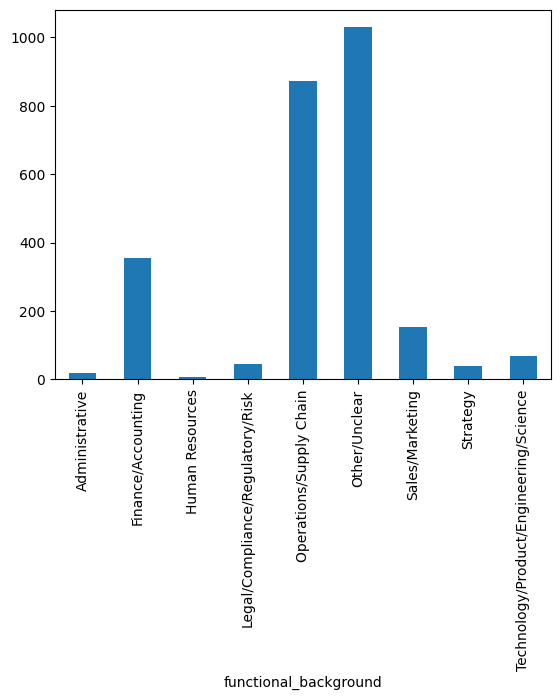

In [160]:
# get unique execid and functional_background. visualize the distribution
final_df_select.drop_duplicates(subset=['execid', 'functional_background']).groupby('functional_background').size().plot(kind='bar')

In [161]:
final_df_select.drop_duplicates(subset=['gvkey', 'year', 'execid'], inplace=True)

/var/folders/qr/1pq07r555gxgt22gqksl2tlw0000gn/T/ipykernel_83142/2915913080.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_select.drop_duplicates(subset=['gvkey', 'year', 'execid'], inplace=True)


In [162]:
database = database.merge(final_df_select[['gvkey', 'year', 'execid', 'functional_background']], how='left', on=['gvkey', 'year', 'execid'])

# 12 - Add FLS, Guidance, Sentiment

In [163]:
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

import pandas as pd

## FLS function

In [164]:

import ssl
# Bypass SSL certificate verification
ssl._create_default_https_context = ssl._create_unverified_context

# Ensure you have the required nltk resources
nltk.download('punkt')


[nltk_data] Downloading package punkt to /Users/majid/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [165]:

def is_forward_looking(sentence, current_year):
    # Define the keywords and conjugations for forward-looking criteria
    keywords = [
        "will", "future", "next fiscal", "next month", "next period", "next quarter", "next year",
        "incoming fiscal", "incoming month", "incoming period", "incoming quarter", "incoming year",
        "coming fiscal", "coming month", "coming period", "coming quarter", "coming year",
        "upcoming fiscal", "upcoming month", "upcoming period", "upcoming quarter", "upcoming year",
        "subsequent fiscal", "subsequent month", "subsequent period", "subsequent quarter", "subsequent year",
        "following fiscal", "following month", "following period", "following quarter", "following year"
    ]

    excluded_keywords = ["shall", "should", "can", "could", "may", "might"]

    verbs = [
        "aim", "anticipate", "assume", "commit", "estimate", "expect",
        "forecast", "foresee", "hope", "intend", "plan", "project",
        "seek", "target"
    ]

    verb_conjugations = [
        "we ", "and ", "but ", "do not ", "company ", "corporation ", "firm ", "management ",
        "and ", "but ", "does not ", "is ", "are ", "not ", "is ", "are ", "not ",
        "normally ", "normally ", "currently ", "currently ", "also ", "also "
    ]

    # Search 1: Keyword based search
    for keyword in keywords:
        if keyword in sentence and not any(excluded in sentence for excluded in excluded_keywords):
            return True

    # Search 2: Verb conjugation based search
    for verb in verbs:
        for conj in verb_conjugations:
            if f"{conj}{verb}" in sentence:
                return True

    # Search 3: Year reference based search
    year_matches = re.findall(r'\b(20\d{2})\b', sentence)
    for year in year_matches:
        if int(year) > current_year:
            return True

    return False

def measure_forward_looking_statements(transcript, current_year):
    sentences = sent_tokenize(transcript)
    total_sentences = len(sentences)
    total_words = sum(len(word_tokenize(sentence)) for sentence in sentences)

    forward_looking_sentences = 0
    forward_looking_words = 0

    for sentence in sentences:
        if is_forward_looking(sentence, current_year):
            forward_looking_sentences += 1
            forward_looking_words += len(word_tokenize(sentence))

    forward_looking_sentence_ratio = forward_looking_sentences / total_sentences if total_sentences > 0 else 0
    forward_looking_word_ratio = forward_looking_words / total_words if total_words > 0 else 0

    return forward_looking_sentence_ratio, forward_looking_word_ratio


In [166]:

# Example usage
call_transcript = """
Thank you, Brett. It was a record third quarter powered by the continued strength of Microsoft Cloud, which surpassed $35 billion in revenue, up 23%. Microsoft Copilot and Copilot stack spanning everyday productivity, business process and developer services to models, data and infrastructure are orchestrating a new era of AI transformation driving better business outcomes across every role and industry. Now I'll highlight examples walking up the stack, starting with AI infrastructure.

Azure again took share as customers use our platforms and tools to build their own AI solutions. We offer the most diverse selection of AI accelerators, including the latest from NVIDIA, AMD, as well as our own first-party silicon. Our AI innovation continues to build on our strategic partnership with OpenAI, more than 65% of the Fortune 500 now use Azure OpenAI service. We also continue to innovate and partner broadly to bring customers the best selection of frontier models in open-source models, LLMs, and SLMs with 53, which we announced earlier this week, we offer the most capable and cost-effective SLM available.

It's already being trialed by companies like CallMiner, LTIMindtree, PwC, and TCS. Our models as a service offering makes it easy for developers to use LLM and SLM without having to manage any underlying infrastructure. Hundreds of paid customers from Accenture and EY to Schneider Electric are using it to take advantage of API access to third-party models, including as of this quarter, the latest from Cohere, Meta, and Mistral. And as part of our partnership announced last week, G42 will run its AI applications and services on our cloud.

All up, the number of Azure AI customers continues to grow and average spend continues to increase. We also saw an acceleration of revenue from migrations to Azure. Azure Arc continues to help customers like DICK'S Sporting Goods and World Bank streamlined their cloud migrations. Arc now has 33,000 customers, up over 2x year over year, and we are the hyperscale platform of choice for SAP and Oracle workloads with Conduent and Medline moving their on-premise Oracle Estates to Azure and Kyndryl and L'Oreal migrating their SAP workloads to Azure.

Overall, we are seeing an acceleration in the number of large Azure deals from leaders across industries, including billion-dollar-plus, multiyear commitments announced this month from Cloud Software Group and the Coca-Cola Company. The number of $100 million-plus Azure deals increased over 80% year over year, while the number of $10 million-plus deals more than doubled. Now on to data and analytics. Our Microsoft intelligent data platform provides customers with the broadest capability, spanning databases, analytics, business intelligence, governance, and AI.

Over half of our Azure AI customers also use our data and analytics tools. Customers are building intelligent applications running on Azure, PostgreSQL, and Cosmos DB with deep integrations with Azure AI. TomTom is a great example. They've used Cosmos DB along with Azure Open AI service to build their own immersive in-car infotainment system.

We are also encouraged by our momentum with our next-generation analytics platform, Microsoft Fabric. Fabric now has over 11,000 paid customers, including leaders in every industry from ABB, EDP, Energy Transfer to Equinor, Foot Locker, ITOCHU, and Lumen, and we are seeing increased usage intensity. Fabric is seamlessly integrated with Azure AI studio meaning customers can run models against enterprise data that's consolidated in Fabric's multi-cloud data lake, OneLake. And Power BI, which is also natively integrated with Fabric provides business users with AI-powered insights.

We now have over 350,000 paid customers. Now on to developers. GitHub Copilot is bending the productivity curve for developers. We now have 1.8 million paid subscribers with growth accelerating to over 35% quarter over quarter and continues to see increased adoption from businesses in every industry, including Itau, Lufthansa Systems, Nokia, Pinterest, and Volvo cars.

Copilot is driving growth across the broader GitHub platform, too. AT&T, Citigroup, and Honeywell all increased their overall getup usage after seeing productivity and code quality increases with Copilot. All up more than 90% of the Fortune 100 are now GitHub customers and revenue accelerated over 45% year over year. Anyone can be a developer with new AI-powered features across our low-code, no-code tools, which makes it easier to build an app, automate workflow or create a Copilot using natural language.

Thirty thousand organizations across every industry have used Copilot studio to customize Copilot for Microsoft 365 or build their own, up 175% quarter over quarter. Cineplex, for example, built a Copilot for customer service agents, reducing query handling time from as much as 15 minutes to 30 seconds. All up over 330,000 organizations, including over half of Fortune 100 have used AI-powered capabilities in Power Platform, and Power Apps now has over 25 million monthly active users, up over 40% year over year. Now on to future of work.

We are seeing AI democratize expertise across the workforce. What inventory turns are to efficiency of supply chains, knowledge turns, the creation and diffusion, and knowledge are to productivity of an organization and Copilot for Microsoft 365 is helping increase knowledge turns. Thus, having a cascading effect changing work, work artifacts, and workflows, and driving better decision-making, collaboration and efficiency. This quarter, we made Copilot available to organizations of all types and sizes from enterprises to small businesses, nearly 60% of the Fortune 500 now use Copilot and we have seen accelerated adoption across industries and geographies with companies like Amgen, BP, Cognizant, Koch Industries, Moody's, Novo Nordisk, NVIDIA, and Tech Mahindra purchasing over 10,000 seats.

We're also seeing increased usage intensity from early adopters, including a nearly 50% increase in the number of Copilot-assisted interactions per user in Teams, bridging group activity with business process workflows and enterprise knowledge. And we're not stopping there. We're accelerating our innovation, adding over 150 Copilot capabilities since the start of the year. With Copilot in Dynamics 365, we are helping businesses transform every role in business function as we take share with our AI-powered apps across all categories.

This quarter, we made our Copilot for service and Copilot for sales broadly available, helping customer service agents and sellers at companies like Land O'Lakes, Northern Trust, Rockwell Automation, and Toyota Group generate role-specific insights and recommendations from across Dynamics 365 and Microsoft 365, as well as third-party platforms like Salesforce, ServiceNow, and Zendesk. And with our Copilot for finance, we are drawing context from dynamics, as well as ERP systems like SAP to reduce labor-intensive processes like collections and contract and invoice capture for companies like dentsu and IDC. ISVs are also building their own Copilot integrations. For example, new integrations between Adobe Experience Cloud and Copilot will help marketers access campaign insights in the flow of their work.

When it comes to devices, Copilot in Windows is now available on nearly 225 million Windows 10 and Windows 11 PCs, up two times quarter over quarter. With Copilot, we have an opportunity to create an entirely new category of devices, purpose built for this new generation of AI. All of our largest OEM partners have announced AI PCs in recent months. And this quarter, we introduced new surface devices, which include integrated NPUs to power on-device AI experiences like auto framing and live captions.

And there's much more to come in just a few weeks, we'll hold a special event to talk about our AI vision across Windows and devices. When it comes to Teams, we once again saw year-over-year usage growth. We're rolling out a new version, which is up to two times faster while using 50% less memory for all customers. We surpassed 1 million Teams rooms for the first time as we continue to make hybrid meetings better with new AI-powered features like automatic camera switching and speaker recognition.

And Teams Phone continues to be the market leader in cloud calling now with over 20 million PSTN users, up nearly 30% year over year. All of this innovation is driving growth across Microsoft 365 companies across the private and public sector, including Amadeus, BlackRock, Chevron, Ecolab, Kimberly Clark, all chose our premium E5 offerings this quarter for advanced security, compliance, voice, and analytics. Now on to industry and cross-industry clouds. We are also bringing AI-powered transformation to every industry.

In healthcare, DAX Copilot is being used by more than 200 healthcare organizations, including Providence, Stanford Health Care, and WellSpan Health. And in manufacturing, this week, at HANNOVER MESSE, customers like BMW, Siemens, and Volvo Penta, shared how they're using our cloud and AI solutions to transform factory operations. Now on to security. Security underpins every layer of the tech stack and it's our No.

1 priority. We launched our Secure Future Initiative last fall for this reason, bringing together every part of the company to advance cybersecurity protection and we are doubling down on this very important work, putting security about all else before all other features and investments. We are focused on making continuous progress across the six pillars of this initiative as we protect tenants and isolate production systems, protect identities and secrets, protect networks, protect engineering systems, monitor and detect threats, and accelerate responses and remediation. We remain committed to sharing our learnings, tools, and innovation with customers.

A great example is Copilot for security, which we made generally available earlier this month, bringing together LLM with domain-specific skills informed by our threat intelligence and 78 trillion daily security signals to provide security teams with actionable insights. Now let me talk about our consumer businesses, starting with LinkedIn. We continue to combine our unique data with this new generation of AI to transform the way members learn, sell, and get hired. Features like LinkedIn AI-assisted messages are seeing a 40% higher acceptance rate and accepted over 10% faster by jobseekers saving hires, time and making it easier to connect them to candidates.

Our AI-powered collaborative articles, which has reached over 12 million contributions are helping increase engagement on the platform, which reached a new record this quarter. New AI features are also helping accelerate LinkedIn premium growth with revenue up 29% year over year. We are also seeing strength across our other businesses with hiring, taking share for the seventh consecutive quarter. Now on to search advertising and news.

We once again took share across Bing and Edge as we continue to apply this new generation of AI to transform how people search and browse. Bing reached over 140 million daily active users, and we are particularly encouraged by our momentum in mobile. Our free Copilot apps on iOS and Android saw a surge in downloads after our Super Bowl ad and are among the highest-rated in this category. We also rolled out Copilot to our ad platform this quarter, helping marketers use AI to generate recommendations for product images, headlines, and descriptions.

Now on to gaming. We are committed to meeting players where they are by bringing great games to more people on more devices. We set third quarter records for game streaming hours, console usage, and monthly active devices. And last month, we added our first Activision Blizzard title Diablo 4 to our Game Pass service.

Subscribers played over 10 million hours within the first 10 days, making it one of our biggest first-party Game Pass launches ever. We were also encouraged by ongoing success of Call of Duty: Modern Warfare 3, which is attracting new gamers and retaining franchise loyalists. Finally, we are expanding our games to new platforms, bringing four of our fan-favorite titles to Nintendo Switch and Sony PlayStation for the first time. In fact, earlier this month, we had seven games among the top 25 on the PlayStation store more than any other publisher.

In closing, I'm energized about our opportunity ahead as we innovate to help people and businesses thrive in this new era. With that, let me turn it over to Amy.

"""

current_year = 2024
forward_looking_sentence_ratio, forward_looking_word_ratio = measure_forward_looking_statements(call_transcript, current_year)
print(f"Forward-Looking Sentence Ratio: {forward_looking_sentence_ratio:.4f}")
print(f"Forward-Looking Word Ratio: {forward_looking_word_ratio:.4f}")

Forward-Looking Sentence Ratio: 0.0426
Forward-Looking Word Ratio: 0.0323


### Prep the database

In [167]:
import pandas as pd

In [168]:
aggregated_transcripts =pd.read_pickle("../data/sxp1500_presentations_ceo_aggregated.pkl")

In [169]:
aggregated_transcripts.head()

,transcriptid,transcriptcomponentid_list,transcript_text,audiolengthsec,companyid,companyname,companyofperson,componentorder,componenttextpreview,delayreasontypeid,delayreasontypename,exec_fullname,execid,gvkey,headline,is_ceo,isdelayed_flag,keydeveventtypeid,keydeveventtypename,keydevid,matched_name,mostimportantdateutc,mostimportanttimeutc,proid,speakertypeid,speakertypename,transcriptcollectiontypeid,transcriptcollectiontypename,transcriptcomponenttypeid,transcriptcomponenttypename,transcriptcreationdate_utc,transcriptcreationtime_utc,transcriptpersonid,transcriptpersonname,transcriptpresentationtypeid,transcriptpresentationtypename,word_count,year,transcript_text_len,transcriptcomponentid_ceospeech,processed
0,45107.0,[3450953.0],"Thanks, Doug, and good afternoon everyone. Tha...",None,4803544.0,"AngioDynamics, Inc.",None,3,"Thanks, Doug, and good afternoon everyone. Tha...",None,None,Johannes C. M. Keltjens,46669,264387,"AngioDynamics Inc., Q2 2010 Earnings Call, Jan...",True,0,48.0,Earnings Calls,83155676.0,Johannes C. M. Keltjens,2010-01-05,21:30:00.000000,None,2,Executives,6,SA Edited Copy,2,Presenter Speech,2010-01-06,04:28:29.000000,130722.0,Johannes C. Keltjens,5,Final,1425.0,2010,8651,3450953.0,0
1,45212.0,"[3457811.0, 3457813.0]","Thank you, John, and good morning to everyone,...",3600.0,189424.0,"Team, Inc.",None,2,"Thank you, John, and good morning to everyone,...",None,None,Phillip J. Hawk,49854,10353,"Team Inc., Q2 2010 Earnings Call, Jan-06-2010",True,0,48.0,Earnings Calls,83711353.0,Phillip J. Hawk,2010-01-06,14:00:00.000000,189428.0,2,Executives,1,Proofed Copy,2,Presenter Speech,2010-01-06,23:55:33.000000,116628.0,Philip Hawk,5,Final,166.0,2010,12012,3457811.0,0
2,45220.0,"[3458448.0, 3458450.0]","Thank you, Jasmine, and good morning. Welcome ...",5940.0,299095.0,RPM International Inc.,None,2,"Thank you, Jasmine, and good morning. Welcome ...",None,None,Frank C. Sullivan,08743,8902,"RPM International Inc., Q2 2010 Earnings Call,...",True,0,48.0,Earnings Calls,79350390.0,Frank C. Sullivan,2010-01-06,15:00:00.000000,299102.0,2,Executives,1,Proofed Copy,2,Presenter Speech,2010-01-07,00:36:48.000000,116583.0,Frank Sullivan,5,Final,435.0,2010,4481,3458448.0,0
3,45248.0,"[3460066.0, 3460069.0]","Thank you, Cathy, and good afternoon, everyone...",3480.0,314750.0,"Worthington Industries, Inc.",None,3,"Thank you, Cathy, and good afternoon, everyone...",None,None,John P. McConnell,03497,11600,"Worthington Industries, Inc., Q2 2010 Earnings...",True,0,48.0,Earnings Calls,83751647.0,John P. McConnell,2010-01-06,18:30:00.000000,314753.0,2,Executives,1,Proofed Copy,2,Presenter Speech,2010-01-07,06:13:10.000000,102758.0,John McConnell,5,Final,217.0,2010,3332,3460066.0,0
4,45259.0,[3460878.0],"Thank you, Len. Good afternoon, everyone and t...",2820.0,321778.0,Bed Bath & Beyond Inc.,None,4,"Thank you, Len. Good afternoon, everyone and t...",None,None,Steven H. Temares,13517,25338,"Bed Bath & Beyond, Inc., Q3 2010 Earnings Call...",True,0,48.0,Earnings Calls,83536034.0,Steven H. Temares,2010-01-06,22:00:00.000000,321785.0,2,Executives,1,Proofed Copy,2,Presenter Speech,2010-01-07,08:37:54.000000,116225.0,Steven Temares,5,Final,819.0,2010,5320,3460878.0,0


In [170]:
# test the function on the first transcript
forward_looking_sentence_ratio, forward_looking_word_ratio = measure_forward_looking_statements(aggregated_transcripts['transcript_text'][0], aggregated_transcripts['year'][0])

In [171]:
# are there duplicates for transcriptid?
aggregated_transcripts['transcriptid'].nunique() == aggregated_transcripts.shape[0]

True

In [172]:
# apply the function to all transcripts, save in two new columns the forward looking sentence ratio and the forward looking word ratio
aggregated_transcripts[['forward_looking_sentence_ratio', 'forward_looking_word_ratio']] = aggregated_transcripts.apply(lambda x: pd.Series(measure_forward_looking_statements(x['transcript_text'], x['year'])), axis=1)

In [173]:
# print summary statistics of the forward looking sentence ratio and the forward looking word ratio
print(aggregated_transcripts[['forward_looking_sentence_ratio', 'forward_looking_word_ratio']].describe())

       forward_looking_sentence_ratio  forward_looking_word_ratio
count                    69248.000000                69248.000000
mean                         0.162004                    0.188204
std                          0.081321                    0.095204
min                          0.000000                    0.000000
25%                          0.103448                    0.120318
50%                          0.153846                    0.178492
75%                          0.210526                    0.245239
max                          0.764706                    0.872093


In [174]:
# save the dataframe with the new columns; only transcriptid and the two new columns
aggregated_transcripts[['transcriptid', 'forward_looking_sentence_ratio', 'forward_looking_word_ratio']].to_pickle("../data/sxp1500_presentations_ceo_aggregated_forward_looking_v11.pkl")

## Guidance data

In [175]:
guidance = pd.read_stata("../data/guidance_data_bill_20240616.dta")

In [176]:
guidance.head()

,GVKEY,PERMNO,TICKER,fyearq,fqtr,datadate,rdq,conm,cik,GR_total_pr_cc,GR_FS_quant_pr_cc,GR_FS_qual_pr_cc,GR_nfs_quant_pr_cc,GR_nfs_qual_pr_cc,GR_total_cc,GR_FS_quant_cc,GR_FS_qual_cc,GR_nfs_quant_cc,GR_nfs_qual_cc
0,1004,54594.0,AIR,2005.0,3.0,2006-02-28,2006-03-22,AAR CORP,0000001750,9.0,3.0,5.0,0.0,1.0,8.0,3.0,4.0,0.0,1.0
1,1004,54594.0,AIR,2005.0,4.0,2006-05-31,2006-07-12,AAR CORP,0000001750,7.0,3.0,4.0,0.0,0.0,7.0,3.0,4.0,0.0,0.0
2,1004,54594.0,AIR,2006.0,1.0,2006-08-31,2006-09-20,AAR CORP,0000001750,8.0,1.0,2.0,1.0,4.0,8.0,1.0,2.0,1.0,4.0
3,1004,54594.0,AIR,2006.0,2.0,2006-11-30,2006-12-20,AAR CORP,0000001750,13.0,1.0,8.0,0.0,4.0,10.0,1.0,6.0,0.0,3.0
4,1004,54594.0,AIR,2006.0,3.0,2007-02-28,2007-03-21,AAR CORP,0000001750,17.0,4.0,8.0,0.0,5.0,14.0,4.0,6.0,0.0,4.0


In [177]:
# datadate column to datetime
guidance['datadate'] = pd.to_datetime(guidance['datadate'], format='%Y%m%d')

In [178]:
# datadate column statistics
guidance['datadate'].describe()

count                            90179
mean     2013-06-28 04:15:19.930360576
min                2003-09-30 00:00:00
25%                2009-06-30 00:00:00
50%                2013-03-31 00:00:00
75%                2017-09-30 00:00:00
max                2021-12-31 00:00:00
Name: datadate, dtype: object

In [179]:
# GVKEY column rename to gvkey
guidance.rename(columns={'GVKEY': 'gvkey'}, inplace=True)

In [180]:
# rdq column to datetime
guidance['rdq'] = pd.to_datetime(guidance['rdq'], format='%Y%m%d')

## Merge with regressions dataset

In [181]:
# Add the two variables merging on transcriptid
database2 = database.merge(aggregated_transcripts[['transcriptid', 'forward_looking_sentence_ratio', 'forward_looking_word_ratio']], on='transcriptid', how='left')

In [182]:
print(database2[['forward_looking_sentence_ratio', 'forward_looking_word_ratio']].describe())

       forward_looking_sentence_ratio  forward_looking_word_ratio
count                    69058.000000                69058.000000
mean                         0.162042                    0.188245
std                          0.081247                    0.095123
min                          0.000000                    0.000000
25%                          0.103448                    0.120387
50%                          0.153846                    0.178535
75%                          0.210526                    0.245245
max                          0.764706                    0.809769


In [183]:
# datadate format to datetime
# print a sample first
print(database2['datadate'].head())

0   2009-11-30
1   2009-11-30
2   2009-11-30
3   2009-11-30
4   2009-11-30
Name: datadate, dtype: datetime64[ns]


In [184]:
# convert to datetime
database2['datadate'] = pd.to_datetime(database2['datadate'])

In [185]:
# describe datadate
print(database2['datadate'].describe())

count                            68950
mean     2016-10-18 19:02:42.378535424
min                2009-11-30 00:00:00
25%                2013-09-30 00:00:00
50%                2016-12-31 00:00:00
75%                2019-12-31 00:00:00
max                2022-11-30 00:00:00
Name: datadate, dtype: object


In [186]:
# mostimportantdateutc format to datetime
database2['mostimportantdateutc'] = pd.to_datetime(database2['mostimportantdateutc'])

In [187]:
# merge the guidance data with the database based on gvkey and datadate
database2 = database2.merge(guidance, on=['gvkey', 'datadate'], how='left')

## Sentiment data

In [189]:
# load mcdonald dictionary
mcd_dic = pd.read_csv('../data/Loughran-McDonald_MasterDictionary_1993-2023.csv')

In [190]:
mcd_dic.columns


Index(['Word', 'Seq_num', 'Word Count', 'Word Proportion',
       'Average Proportion', 'Std Dev', 'Doc Count', 'Negative', 'Positive',
       'Uncertainty', 'Litigious', 'Strong_Modal', 'Weak_Modal',
       'Constraining', 'Complexity', 'Syllables', 'Source'],
      dtype='object')

In [191]:
import pandas as pd
from collections import Counter
import re


In [192]:

# Assuming `df` is your dataframe containing the earnings calls transcripts in the column 'transcript_text'
# Assuming `mcd_dic` is your dataframe containing the words categorized by 'Negative', 'Positive', etc.

# Lists of words converted to lowercase
negative_list = set(mcd_dic[mcd_dic['Negative'] > 0]['Word'].str.lower().tolist())
positive_list = set(mcd_dic[mcd_dic['Positive'] > 0]['Word'].str.lower().tolist())
uncertainty_list = set(mcd_dic[mcd_dic['Uncertainty'] > 0]['Word'].str.lower().tolist())
litigious_list = set(mcd_dic[mcd_dic['Litigious'] > 0]['Word'].str.lower().tolist())
strong_modal_list = set(mcd_dic[mcd_dic['Strong_Modal'] > 0]['Word'].str.lower().tolist())
weak_modal_list = set(mcd_dic[mcd_dic['Weak_Modal'] > 0]['Word'].str.lower().tolist())
complexity_list = set(mcd_dic[mcd_dic['Complexity'] > 0]['Word'].str.lower().tolist())

# Function to count occurrences of words from a list in a text using Counter
def count_words(text, word_set):
    words = re.findall(r'\w+', text.lower())  # Convert text to lowercase and find all words
    counter = Counter(words)
    count = sum(counter[word] for word in word_set)
    return count


In [193]:
# Convert transcript_text column to lowercase
aggregated_transcripts['transcript_text'] = aggregated_transcripts['transcript_text'].str.lower()

In [194]:
# Apply the function to each transcript and create new columns
aggregated_transcripts['negative_count'] = aggregated_transcripts['transcript_text'].apply(lambda x: count_words(x, negative_list))
print('negative count done')

aggregated_transcripts['positive_count'] = aggregated_transcripts['transcript_text'].apply(lambda x: count_words(x, positive_list))
print('positive count done')

aggregated_transcripts['uncertainty_count'] = aggregated_transcripts['transcript_text'].apply(lambda x: count_words(x, uncertainty_list))
print('uncertainty count done')

aggregated_transcripts['complexity_count'] = aggregated_transcripts['transcript_text'].apply(lambda x: count_words(x, complexity_list))

# Calculate total word count for each transcript
aggregated_transcripts['total_word_count'] = aggregated_transcripts['transcript_text'].apply(lambda x: len(re.findall(r'\w+', x.lower())))


negative count done
positive count done
uncertainty count done


In [195]:
# calculate the ratio of each sentiment word count to the total word count
aggregated_transcripts['negative_ratio'] = aggregated_transcripts['negative_count'] / aggregated_transcripts['total_word_count']
aggregated_transcripts['positive_ratio'] = aggregated_transcripts['positive_count'] / aggregated_transcripts['total_word_count']
aggregated_transcripts['uncertainty_ratio'] = aggregated_transcripts['uncertainty_count'] / aggregated_transcripts['total_word_count']
aggregated_transcripts['complexity_ratio'] = aggregated_transcripts['complexity_count'] / aggregated_transcripts['total_word_count']

# add positve - negative / total * 100
aggregated_transcripts['sentiment_score'] = (aggregated_transcripts['positive_count'] - aggregated_transcripts['negative_count']) / aggregated_transcripts['total_word_count'] * 100

In [196]:
# print descriptive statistics of the sentiment ratios
print(aggregated_transcripts[['negative_ratio', 'positive_ratio', 'uncertainty_ratio', 'complexity_ratio', 'sentiment_score']].describe())

       negative_ratio  positive_ratio  uncertainty_ratio  complexity_ratio   
count    69248.000000    69248.000000       69248.000000      69248.000000  \
mean         0.007534        0.024554           0.006371          0.002062   
std          0.005499        0.009089           0.003913          0.002355   
min          0.000000        0.000000           0.000000          0.000000   
25%          0.003723        0.018217           0.003636          0.000000   
50%          0.006378        0.024000           0.005772          0.001400   
75%          0.010060        0.030209           0.008432          0.003076   
max          0.166667        0.130435           0.054608          0.037829   

       sentiment_score  
count     69248.000000  
mean          1.701999  
std           1.131937  
min         -16.666667  
25%           0.971896  
50%           1.702128  
75%           2.435065  
max           8.695652  


In [197]:
# add the new columns, merging on transcriptid
database2 = database2.merge(aggregated_transcripts[['transcriptid', 'negative_ratio', 'positive_ratio', 'uncertainty_ratio',  'complexity_ratio', 'sentiment_score']], on='transcriptid', how='left')

# 13 - Uncertainty Data

## Risk Data

In [199]:
# open firmquarter_2022q1.csv
uncertainty = pd.read_stata('../data/firmquarter_2022q1.dta')

In [200]:
uncertainty.head()

,gvkey,date,PRisk,NPRisk,Risk,PSentiment,NPSentiment,Sentiment,PRiskT_economic,PRiskT_environment,PRiskT_trade,PRiskT_institutions,PRiskT_health,PRiskT_security,PRiskT_tax,PRiskT_technology,company_name,hqcountrycode,isin,cusip,ticker,date_earningscall,Covid_Exposure,Covid_Neg_Sentiment,Covid_Pos_Sentiment,Covid_Net_Sentiment,Covid_Risk,SARS_Exposure,H1N1_Exposure,Zika_Exposure,Ebola_Exposure,Brexit_Exposure,Brexit_Neg_Sentiment,Brexit_Pos_Sentiment,Brexit_Net_Sentiment,Brexit_Risk
0,001004,2002-01-01,359.550717,2928.601353,168.982351,997.864152,5550.580665,469.395419,9001.562500,6331.430176,8942.732422,3561.493408,6755.946777,4922.558105,4933.755371,9790.708984,AAR Corp,US,US0003611052,000361105,AIR,20-Mar-2002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,001004,2002-04-01,0.000000,0.000000,0.000000,1594.732147,-5656.607357,544.824170,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,AAR Corp,US,US0003611052,000361105,AIR,27-Jun-2002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,001004,2002-07-01,0.000000,0.000000,0.000000,49.334494,-17818.418427,318.471338,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,AAR Corp,US,US0003611052,000361105,AIR,26-Sep-2002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,001004,2003-07-01,0.000000,0.000000,0.000000,2581.944092,81710.482710,1314.828342,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,AAR Corp,US,US0003611052,000361105,AIR,17-Sep-2003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,001004,2003-10-01,0.000000,298.871602,97.087379,2008.371500,81338.761583,1747.572816,2291.365969,2100.714942,963.631448,4163.550979,2500.242534,2388.684727,3250.849740,373.608619,AAR Corp,US,US0003611052,000361105,AIR,18-Dec-2003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [201]:
uncertainty.columns

Index(['gvkey', 'date', 'PRisk', 'NPRisk', 'Risk', 'PSentiment', 'NPSentiment',
       'Sentiment', 'PRiskT_economic', 'PRiskT_environment', 'PRiskT_trade',
       'PRiskT_institutions', 'PRiskT_health', 'PRiskT_security', 'PRiskT_tax',
       'PRiskT_technology', 'company_name', 'hqcountrycode', 'isin', 'cusip',
       'ticker', 'date_earningscall', 'Covid_Exposure', 'Covid_Neg_Sentiment',
       'Covid_Pos_Sentiment', 'Covid_Net_Sentiment', 'Covid_Risk',
       'SARS_Exposure', 'H1N1_Exposure', 'Zika_Exposure', 'Ebola_Exposure',
       'Brexit_Exposure', 'Brexit_Neg_Sentiment', 'Brexit_Pos_Sentiment',
       'Brexit_Net_Sentiment', 'Brexit_Risk'],
      dtype='object')

In [202]:
uncertainty = uncertainty[['gvkey', 'PRisk', 'NPRisk', 'date_earningscall']]

In [203]:
# change date_earningscall to datetime
# it is currently like 27-Jun-2002	
uncertainty['date_earningscall_dt'] = pd.to_datetime(uncertainty['date_earningscall'], format='%d-%b-%Y')
uncertainty['gvkey'] = uncertainty['gvkey'].astype(int)



In [204]:
uncertainty.date_earningscall_dt

0        2002-03-20
1        2002-06-27
2        2002-09-26
3        2003-09-17
4        2003-12-18
            ...    
354513   2022-03-24
354514   2022-02-11
354515   2021-11-27
354516   2022-02-08
354517   2022-03-24
Name: date_earningscall_dt, Length: 354518, dtype: datetime64[ns]

In [205]:
database2.mostimportantdateutc

0       2010-01-05
1       2010-01-06
2       2010-01-06
3       2010-01-06
4       2010-01-06
           ...    
69053   2021-05-04
69054   2021-07-29
69055   2021-08-03
69056   2021-05-04
69057   2021-01-28
Name: mostimportantdateutc, Length: 69058, dtype: datetime64[ns]

In [206]:
database2['mostimportantdateutc'] = pd.to_datetime(database2['mostimportantdateutc'])

In [207]:
# First, sort both DataFrames by their date columns
database2 = database2.sort_values('mostimportantdateutc')
uncertainty = uncertainty.sort_values('date_earningscall_dt')

# Perform an asof merge with a 30-day tolerance
database3 = pd.merge_asof(
    database2,
    uncertainty,
    left_on='mostimportantdateutc',
    right_on='date_earningscall_dt',
    by='gvkey',
    tolerance=pd.Timedelta(days=30),
    direction='nearest'  # Options: 'backward', 'forward', or 'nearest'
)

## Economic Policy Uncertainty Data

In [208]:
# US economic data
econ_uncertainty = pd.read_excel('../data/US_Policy_Uncertainty_Data.xlsx')

In [209]:
econ_uncertainty.columns

Index(['Year', 'Month', 'Three_Component_Index',
       'News_Based_Policy_Uncert_Index'],
      dtype='object')

In [210]:
econ_uncertainty.columns = econ_uncertainty.columns.str.lower()

In [211]:
# drop the last row of data in econ_uncertainty
econ_uncertainty = econ_uncertainty.iloc[:-1]


In [212]:
# make year and month int in both dataframes; drop if an issue 
econ_uncertainty['year'] = econ_uncertainty['year'].astype(int)



In [213]:
# create trailing average of 12 month of US economic uncertainty
econ_uncertainty['trailing_12month_uncertainty_3component'] = econ_uncertainty['three_component_index'].transform(lambda x: x.rolling(window=12).mean())
econ_uncertainty['trailing_12month_uncertainty_newsbased'] = econ_uncertainty['news_based_policy_uncert_index'].transform(lambda x: x.rolling(window=12).mean())

In [214]:
econ_uncertainty.columns = ['year_1month_lag', 'month_1month_lag', 'three_component_index',
       'news_based_policy_uncert_index',
       'trailing_12month_uncertainty_3component',
       'trailing_12month_uncertainty_newsbased']

In [215]:
# merge with same year but previous month in database3
database3['date_1month_lag'] = database3['mostimportantdateutc'] - pd.DateOffset(months=0)
database3['year_1month_lag'] = database3['date_1month_lag'].dt.year
database3['month_1month_lag'] = database3['date_1month_lag'].dt.month

In [216]:
database4 = pd.merge(database3, econ_uncertainty, on=['year_1month_lag', 'month_1month_lag'], how='left')

# 14 - Slack vars

In [217]:

###############################################################################
# STEP 1: DOWNLOAD QUARTERLY DATA (no SICH) & ANNUAL DATA (with SICH)
###############################################################################

previously_downloaded_compustat_quarterly_slack = True
if not previously_downloaded_compustat_quarterly_slack:
    db = wrds.Connection()
    
    # -------------------------------------------------------------------------
    # 1A. Query QUARTERLY data (fundq) - does NOT have SICH, but we need at, sale, che, emp, etc.
    #     We'll alias fyearq AS fyear for easy merging later.
    # -------------------------------------------------------------------------
    query_q = """
        SELECT
            gvkey,
            datadate,
            fyearq AS fyear,        -- rename so we can merge on 'fyear'
            fqtr,                   -- fiscal quarter if needed
            cusip,
            atq  AS at,             -- total assets (quarterly)
            saleq AS sale,          -- net sales (quarterly)
            cheq AS che,            -- cash & short-term investments (quarterly)
            cogsq AS cogs,          -- cost of goods sold
            revtq AS revt           -- total revenue
        FROM comp_na_daily_all.fundq
        WHERE fyearq >= 2002
          AND indfmt = 'INDL'
          AND datafmt = 'STD'
          AND popsrc = 'D'
          AND consol = 'C'
    """
    compustat_q_slack = db.raw_sql(query_q)
    
    # -------------------------------------------------------------------------
    # 1B. Query ANNUAL data (funda) - we only need gvkey, fyear, and sich for the merge
    # -------------------------------------------------------------------------
    query_a_sich = """
        SELECT
            gvkey,
            fyear,
            sich,
            emp
        FROM comp_na_daily_all.funda
        WHERE fyear >= 2002
          AND indfmt = 'INDL'
          AND datafmt = 'STD'
          AND popsrc = 'D'
          AND consol = 'C'
    """
    compustat_a_sich = db.raw_sql(query_a_sich)
    
    # Save both
    compustat_q_slack.to_pickle('compustat_q_slack.pkl')
    compustat_a_sich.to_pickle('compustat_a_sich.pkl')
    
    db.close()
else:
    compustat_q_slack = pd.read_pickle('compustat_q_slack.pkl')
    compustat_a_sich  = pd.read_pickle('compustat_a_sich.pkl')


In [218]:

###############################################################################
# STEP 2: MERGE ANNUAL SICH INFO ONTO QUARTERLY DATA
#         We will match on (gvkey, fyear).
###############################################################################

# Just keep the columns needed for merging: gvkey, fyear, sich
compustat_a_sich = compustat_a_sich[['gvkey','fyear','sich', 'emp']].drop_duplicates()

# Merge left: keep all quarterly obs, bring in 'sich' from annual
compustat_q_slack = pd.merge(
    compustat_q_slack,
    compustat_a_sich,
    how='left',
    on=['gvkey','fyear']    # merges annual fyear with quarterly fyear
)


In [219]:


# Convert numeric columns if needed
numeric_cols = ['at','sale','che','emp','cogs','revt']
for col in numeric_cols:
    compustat_q_slack[col] = pd.to_numeric(compustat_q_slack[col], errors='coerce')

# Drop rows with missing or zero in key fields used for slack
compustat_q_slack.dropna(subset=['at','sale','che','emp'], inplace=True)
compustat_q_slack = compustat_q_slack[compustat_q_slack['at'] > 0]
compustat_q_slack = compustat_q_slack[compustat_q_slack['sale'] > 0]

# If you want a 'year' column (already have fyear from the quarterly dataset),
# just rename or confirm it:
compustat_q_slack['year'] = compustat_q_slack['fyear']



compustat_q_slack['gross_profit'] = compustat_q_slack['revt'] - compustat_q_slack['cogs']
compustat_q_slack['perf_gpa'] = compustat_q_slack['gross_profit'] / compustat_q_slack['at']

###############################################################################
# STEP 5: CONSTRUCT FINANCIAL SLACK & HR SLACK
#         - FIN_SLACK = (che / at) minus industry-year mean
###############################################################################

# (a) raw ratios
compustat_q_slack['fin_slack_raw'] = compustat_q_slack['che'] / compustat_q_slack['at']

# (b) ensure sich is string for grouping
compustat_q_slack['sich'] = compustat_q_slack['sich'].fillna('0000').astype(str)

# (c) group by year & sich
group_cols = ['year','sich']

compustat_q_slack['fin_slack_mean'] = compustat_q_slack.groupby(group_cols)['fin_slack_raw'].transform('mean')


for col in ['fin_slack_ind_adjusted','fin_slack_raw','perf_gpa']:
    lower_q = compustat_q_slack[col].quantile(0.005)
    upper_q = compustat_q_slack[col].quantile(0.995)
    compustat_q_slack[col] = np.clip(compustat_q_slack[col], lower_q, upper_q)




In [220]:
compustat_q_slack = compustat_q_slack[['gvkey', 'datadate', 'fin_slack_ind_adjusted','fin_slack_raw','perf_gpa']]

In [221]:
compustat_q_slack['datadate'] = pd.to_datetime(compustat_q_slack['datadate'])
compustat_q_slack['gvkey'] = compustat_q_slack['gvkey'].astype(int)
compustat_q_slack.drop_duplicates(subset=['gvkey', 'datadate'], inplace=True)


In [222]:
database5 = pd.merge(database4, compustat_q_slack, on=['gvkey', 'datadate'], how='left')

# 15 - Cleaning up Saving

In [223]:
final_db = database5.copy()

In [224]:
# replace database['ceo_years_left']  with nan if 0
final_db['ceo_years_left'] = final_db['ceo_years_left'].replace(0, np.nan)

In [225]:
# winsorize earnings_surprise var in 1 percentile
from scipy.stats.mstats import winsorize

final_db['earnings_surprise_wins'] = winsorize(final_db['earnings_surprise'], limits=[0.025, 0.025])

In [226]:
# Remove rows with missing or infinite values in 'promises_count' or 'ratio_roa'

final_db['ceo_options_compensation_log'] = np.log(final_db['ceo_options_compensation']+1)
final_db['ceo_dual_dummy'] = np.where(final_db['ceo_dual']==1, 1, 0) 
final_db['numest'].fillna(0, inplace=True)
final_db['word_count_total_log'] = np.log(final_db['word_count_total']+1)
final_db['ceo_last_3_years'] = np.where(final_db['ceo_years_left']<=3, 1, 0)
final_db['ceo_last_2_years'] = np.where(final_db['ceo_years_left']<=2, 1, 0)
final_db['ceo_last_1_years'] = np.where(final_db['ceo_years_left']<=1, 1, 0)

final_db['at_log'] = np.log(final_db['atq']+1)
final_db.sort_values(by=['gvkey','mostimportantdateutc'], inplace=True)


final_db['roe_sq'] = final_db['roe']**2

final_db['constant'] = 1

In [227]:
# save to stata
# first make sure that the variables are in the right format, no infitie values, etc.
final_db.replace([np.inf, -np.inf], np.nan).to_csv('../data/sxp1500_presentations_ceo_aggregated_regression_vars.csv', index=False)